In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "HDD"
station_dv = "HDD (degC-day)"
station_path = "data/station_inputs/hdd_Tmax_Tmin_allstations_v3_for_maps.csv"
input_model_path = "data/model_inputs/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc"
medians = {"value": 5045, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,HDD (degC-day),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,3556.025000,-4.517790,10.457750,42.0333,-82.9000,191,HARROW CDA,ON,3008.439209,1.173934
1,552,1017,3460.883333,-4.547677,10.753982,41.9500,-82.5167,177,POINT PELEE,ON,3019.692139,1.138267
2,553,1007,3362.187500,-4.474659,10.302673,42.1034,-83.0945,182,AMHERSTBURG,ON,3084.320068,1.082636


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

12882.913546666668

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/1259 [00:00<?, ?it/s]

  0%|          | 2/1259 [00:00<06:47,  3.09it/s]

  0%|          | 3/1259 [00:01<08:57,  2.34it/s]

  0%|          | 4/1259 [00:01<10:13,  2.05it/s]

  0%|          | 5/1259 [00:02<10:56,  1.91it/s]

  0%|          | 6/1259 [00:03<11:25,  1.83it/s]

  1%|          | 7/1259 [00:03<11:52,  1.76it/s]

  1%|          | 8/1259 [00:04<12:07,  1.72it/s]

  1%|          | 9/1259 [00:05<12:28,  1.67it/s]

  1%|          | 10/1259 [00:05<12:31,  1.66it/s]

  1%|          | 11/1259 [00:06<12:34,  1.65it/s]

  1%|          | 12/1259 [00:06<12:33,  1.66it/s]

  1%|          | 13/1259 [00:07<12:36,  1.65it/s]

  1%|          | 14/1259 [00:08<12:32,  1.65it/s]

  1%|          | 15/1259 [00:08<12:34,  1.65it/s]

  1%|▏         | 16/1259 [00:09<12:41,  1.63it/s]

  1%|▏         | 17/1259 [00:09<12:40,  1.63it/s]

  1%|▏         | 18/1259 [00:10<12:48,  1.62it/s]

  2%|▏         | 19/1259 [00:11<12:45,  1.62it/s]

  2%|▏         | 20/1259 [00:11<12:40,  1.63it/s]

  2%|▏         | 21/1259 [00:12<12:32,  1.64it/s]

  2%|▏         | 22/1259 [00:12<12:28,  1.65it/s]

  2%|▏         | 23/1259 [00:13<12:23,  1.66it/s]

  2%|▏         | 24/1259 [00:14<12:20,  1.67it/s]

  2%|▏         | 25/1259 [00:14<12:17,  1.67it/s]

  2%|▏         | 26/1259 [00:15<12:25,  1.65it/s]

  2%|▏         | 27/1259 [00:15<12:21,  1.66it/s]

  2%|▏         | 28/1259 [00:16<12:20,  1.66it/s]

  2%|▏         | 29/1259 [00:17<12:19,  1.66it/s]

  2%|▏         | 30/1259 [00:17<12:20,  1.66it/s]

  2%|▏         | 31/1259 [00:18<12:10,  1.68it/s]

  3%|▎         | 32/1259 [00:18<12:16,  1.67it/s]

  3%|▎         | 33/1259 [00:19<12:23,  1.65it/s]

  3%|▎         | 34/1259 [00:20<12:32,  1.63it/s]

  3%|▎         | 35/1259 [00:20<12:40,  1.61it/s]

  3%|▎         | 36/1259 [00:21<12:54,  1.58it/s]

  3%|▎         | 37/1259 [00:22<12:53,  1.58it/s]

  3%|▎         | 38/1259 [00:22<12:36,  1.61it/s]

  3%|▎         | 39/1259 [00:23<12:43,  1.60it/s]

  3%|▎         | 40/1259 [00:23<12:35,  1.61it/s]

  3%|▎         | 41/1259 [00:24<12:33,  1.62it/s]

  3%|▎         | 42/1259 [00:25<12:28,  1.63it/s]

  3%|▎         | 43/1259 [00:25<12:33,  1.61it/s]

  3%|▎         | 44/1259 [00:26<12:27,  1.63it/s]

  4%|▎         | 45/1259 [00:27<12:24,  1.63it/s]

  4%|▎         | 46/1259 [00:27<12:45,  1.58it/s]

  4%|▎         | 47/1259 [00:28<12:43,  1.59it/s]

  4%|▍         | 48/1259 [00:28<12:43,  1.59it/s]

  4%|▍         | 49/1259 [00:29<12:33,  1.61it/s]

  4%|▍         | 50/1259 [00:30<12:54,  1.56it/s]

  4%|▍         | 51/1259 [00:30<12:55,  1.56it/s]

  4%|▍         | 52/1259 [00:31<12:46,  1.57it/s]

  4%|▍         | 53/1259 [00:32<12:42,  1.58it/s]

  4%|▍         | 54/1259 [00:32<12:32,  1.60it/s]

  4%|▍         | 55/1259 [00:33<12:20,  1.63it/s]

  4%|▍         | 56/1259 [00:33<12:29,  1.61it/s]

  5%|▍         | 57/1259 [00:34<12:15,  1.63it/s]

  5%|▍         | 58/1259 [00:35<12:26,  1.61it/s]

  5%|▍         | 59/1259 [00:35<12:17,  1.63it/s]

  5%|▍         | 60/1259 [00:36<12:09,  1.64it/s]

  5%|▍         | 61/1259 [00:37<12:08,  1.65it/s]

  5%|▍         | 62/1259 [00:37<12:03,  1.65it/s]

  5%|▌         | 63/1259 [00:38<12:12,  1.63it/s]

  5%|▌         | 64/1259 [00:38<12:06,  1.64it/s]

  5%|▌         | 65/1259 [00:39<12:14,  1.62it/s]

  5%|▌         | 66/1259 [00:40<12:16,  1.62it/s]

  5%|▌         | 67/1259 [00:40<12:05,  1.64it/s]

  5%|▌         | 68/1259 [00:41<12:04,  1.64it/s]

  5%|▌         | 69/1259 [00:41<12:05,  1.64it/s]

  6%|▌         | 70/1259 [00:42<12:00,  1.65it/s]

  6%|▌         | 71/1259 [00:43<11:59,  1.65it/s]

  6%|▌         | 72/1259 [00:43<11:56,  1.66it/s]

  6%|▌         | 73/1259 [00:44<12:09,  1.62it/s]

  6%|▌         | 74/1259 [00:44<12:11,  1.62it/s]

  6%|▌         | 75/1259 [00:45<12:10,  1.62it/s]

  6%|▌         | 76/1259 [00:46<12:04,  1.63it/s]

  6%|▌         | 77/1259 [00:46<12:00,  1.64it/s]

  6%|▌         | 78/1259 [00:47<12:07,  1.62it/s]

  6%|▋         | 79/1259 [00:48<12:01,  1.63it/s]

  6%|▋         | 80/1259 [00:48<12:13,  1.61it/s]

  6%|▋         | 81/1259 [00:49<12:06,  1.62it/s]

  7%|▋         | 82/1259 [00:49<11:54,  1.65it/s]

  7%|▋         | 83/1259 [00:50<11:59,  1.63it/s]

  7%|▋         | 84/1259 [00:51<11:55,  1.64it/s]

  7%|▋         | 85/1259 [00:51<12:03,  1.62it/s]

  7%|▋         | 86/1259 [00:52<12:02,  1.62it/s]

  7%|▋         | 87/1259 [00:52<11:56,  1.64it/s]

  7%|▋         | 88/1259 [00:53<11:45,  1.66it/s]

  7%|▋         | 89/1259 [00:54<11:48,  1.65it/s]

  7%|▋         | 90/1259 [00:54<11:52,  1.64it/s]

  7%|▋         | 91/1259 [00:55<12:06,  1.61it/s]

  7%|▋         | 92/1259 [00:56<12:11,  1.60it/s]

  7%|▋         | 93/1259 [00:56<12:14,  1.59it/s]

  7%|▋         | 94/1259 [00:57<12:07,  1.60it/s]

  8%|▊         | 95/1259 [00:57<12:04,  1.61it/s]

  8%|▊         | 96/1259 [00:58<11:57,  1.62it/s]

  8%|▊         | 97/1259 [00:59<12:01,  1.61it/s]

  8%|▊         | 98/1259 [00:59<11:52,  1.63it/s]

  8%|▊         | 99/1259 [01:00<11:57,  1.62it/s]

  8%|▊         | 100/1259 [01:00<11:56,  1.62it/s]

  8%|▊         | 101/1259 [01:01<11:52,  1.62it/s]

  8%|▊         | 102/1259 [01:02<11:53,  1.62it/s]

  8%|▊         | 103/1259 [01:02<11:53,  1.62it/s]

  8%|▊         | 104/1259 [01:03<11:50,  1.63it/s]

  8%|▊         | 105/1259 [01:04<11:42,  1.64it/s]

  8%|▊         | 106/1259 [01:04<11:29,  1.67it/s]

  8%|▊         | 107/1259 [01:05<11:27,  1.68it/s]

  9%|▊         | 108/1259 [01:05<11:36,  1.65it/s]

  9%|▊         | 109/1259 [01:06<11:33,  1.66it/s]

  9%|▊         | 110/1259 [01:07<11:43,  1.63it/s]

  9%|▉         | 111/1259 [01:07<11:44,  1.63it/s]

  9%|▉         | 112/1259 [01:08<11:30,  1.66it/s]

  9%|▉         | 113/1259 [01:08<11:40,  1.64it/s]

  9%|▉         | 114/1259 [01:09<11:39,  1.64it/s]

  9%|▉         | 115/1259 [01:10<11:27,  1.66it/s]

  9%|▉         | 116/1259 [01:10<11:31,  1.65it/s]

  9%|▉         | 117/1259 [01:11<11:23,  1.67it/s]

  9%|▉         | 118/1259 [01:11<11:27,  1.66it/s]

  9%|▉         | 119/1259 [01:12<11:28,  1.66it/s]

 10%|▉         | 120/1259 [01:13<11:21,  1.67it/s]

 10%|▉         | 121/1259 [01:13<11:29,  1.65it/s]

 10%|▉         | 122/1259 [01:14<11:24,  1.66it/s]

 10%|▉         | 123/1259 [01:14<11:21,  1.67it/s]

 10%|▉         | 124/1259 [01:15<11:20,  1.67it/s]

 10%|▉         | 125/1259 [01:16<11:18,  1.67it/s]

 10%|█         | 126/1259 [01:16<11:16,  1.68it/s]

 10%|█         | 127/1259 [01:17<11:18,  1.67it/s]

 10%|█         | 128/1259 [01:17<11:18,  1.67it/s]

 10%|█         | 129/1259 [01:18<11:34,  1.63it/s]

 10%|█         | 130/1259 [01:19<11:28,  1.64it/s]

 10%|█         | 131/1259 [01:19<11:29,  1.64it/s]

 10%|█         | 132/1259 [01:20<11:19,  1.66it/s]

 11%|█         | 133/1259 [01:20<11:15,  1.67it/s]

 11%|█         | 134/1259 [01:21<11:34,  1.62it/s]

 11%|█         | 135/1259 [01:22<11:37,  1.61it/s]

 11%|█         | 136/1259 [01:22<11:32,  1.62it/s]

 11%|█         | 137/1259 [01:23<11:34,  1.62it/s]

 11%|█         | 138/1259 [01:24<11:25,  1.64it/s]

 11%|█         | 139/1259 [01:24<11:18,  1.65it/s]

 11%|█         | 140/1259 [01:25<11:13,  1.66it/s]

 11%|█         | 141/1259 [01:25<11:19,  1.65it/s]

 11%|█▏        | 142/1259 [01:26<11:35,  1.61it/s]

 11%|█▏        | 143/1259 [01:27<11:35,  1.61it/s]

 11%|█▏        | 144/1259 [01:27<11:41,  1.59it/s]

 12%|█▏        | 145/1259 [01:28<11:28,  1.62it/s]

 12%|█▏        | 146/1259 [01:28<11:14,  1.65it/s]

 12%|█▏        | 147/1259 [01:29<11:08,  1.66it/s]

 12%|█▏        | 148/1259 [01:30<11:07,  1.67it/s]

 12%|█▏        | 149/1259 [01:30<11:13,  1.65it/s]

 12%|█▏        | 150/1259 [01:31<11:18,  1.64it/s]

 12%|█▏        | 151/1259 [01:32<11:27,  1.61it/s]

 12%|█▏        | 152/1259 [01:32<11:20,  1.63it/s]

 12%|█▏        | 153/1259 [01:33<11:16,  1.64it/s]

 12%|█▏        | 154/1259 [01:33<11:09,  1.65it/s]

 12%|█▏        | 155/1259 [01:34<11:14,  1.64it/s]

 12%|█▏        | 156/1259 [01:35<11:05,  1.66it/s]

 12%|█▏        | 157/1259 [01:35<11:03,  1.66it/s]

 13%|█▎        | 158/1259 [01:36<10:52,  1.69it/s]

 13%|█▎        | 159/1259 [01:36<10:57,  1.67it/s]

 13%|█▎        | 160/1259 [01:37<10:55,  1.68it/s]

 13%|█▎        | 161/1259 [01:38<11:12,  1.63it/s]

 13%|█▎        | 162/1259 [01:38<11:11,  1.63it/s]

 13%|█▎        | 163/1259 [01:39<11:14,  1.62it/s]

 13%|█▎        | 164/1259 [01:39<11:12,  1.63it/s]

 13%|█▎        | 165/1259 [01:40<11:09,  1.63it/s]

 13%|█▎        | 166/1259 [01:41<11:06,  1.64it/s]

 13%|█▎        | 167/1259 [01:41<11:00,  1.65it/s]

 13%|█▎        | 168/1259 [01:42<11:03,  1.64it/s]

 13%|█▎        | 169/1259 [01:42<10:51,  1.67it/s]

 14%|█▎        | 170/1259 [01:43<10:53,  1.67it/s]

 14%|█▎        | 171/1259 [01:44<10:47,  1.68it/s]

 14%|█▎        | 172/1259 [01:44<10:54,  1.66it/s]

 14%|█▎        | 173/1259 [01:45<11:04,  1.63it/s]

 14%|█▍        | 174/1259 [01:45<11:04,  1.63it/s]

 14%|█▍        | 175/1259 [01:46<10:58,  1.65it/s]

 14%|█▍        | 176/1259 [01:47<10:45,  1.68it/s]

 14%|█▍        | 177/1259 [01:47<10:54,  1.65it/s]

 14%|█▍        | 178/1259 [01:48<10:48,  1.67it/s]

 14%|█▍        | 179/1259 [01:48<11:12,  1.61it/s]

 14%|█▍        | 180/1259 [01:49<11:04,  1.62it/s]

 14%|█▍        | 181/1259 [01:50<10:59,  1.63it/s]

 14%|█▍        | 182/1259 [01:50<11:04,  1.62it/s]

 15%|█▍        | 183/1259 [01:51<10:51,  1.65it/s]

 15%|█▍        | 184/1259 [01:52<10:57,  1.63it/s]

 15%|█▍        | 185/1259 [01:52<11:05,  1.61it/s]

 15%|█▍        | 186/1259 [01:53<10:47,  1.66it/s]

 15%|█▍        | 187/1259 [01:53<10:49,  1.65it/s]

 15%|█▍        | 188/1259 [01:54<10:47,  1.65it/s]

 15%|█▌        | 189/1259 [01:55<10:46,  1.65it/s]

 15%|█▌        | 190/1259 [01:55<10:40,  1.67it/s]

 15%|█▌        | 191/1259 [01:56<10:35,  1.68it/s]

 15%|█▌        | 192/1259 [01:56<10:41,  1.66it/s]

 15%|█▌        | 193/1259 [01:57<10:45,  1.65it/s]

 15%|█▌        | 194/1259 [01:58<10:56,  1.62it/s]

 15%|█▌        | 195/1259 [01:58<11:10,  1.59it/s]

 16%|█▌        | 196/1259 [01:59<11:09,  1.59it/s]

 16%|█▌        | 197/1259 [02:00<11:13,  1.58it/s]

 16%|█▌        | 198/1259 [02:00<11:08,  1.59it/s]

 16%|█▌        | 199/1259 [02:01<11:26,  1.54it/s]

 16%|█▌        | 200/1259 [02:01<11:30,  1.53it/s]

 16%|█▌        | 201/1259 [02:02<11:19,  1.56it/s]

 16%|█▌        | 202/1259 [02:03<11:13,  1.57it/s]

 16%|█▌        | 203/1259 [02:03<11:11,  1.57it/s]

 16%|█▌        | 204/1259 [02:04<11:03,  1.59it/s]

 16%|█▋        | 205/1259 [02:05<10:56,  1.61it/s]

 16%|█▋        | 206/1259 [02:05<11:00,  1.59it/s]

 16%|█▋        | 207/1259 [02:06<11:07,  1.57it/s]

 17%|█▋        | 208/1259 [02:07<11:21,  1.54it/s]

 17%|█▋        | 209/1259 [02:07<11:07,  1.57it/s]

 17%|█▋        | 210/1259 [02:08<11:10,  1.56it/s]

 17%|█▋        | 211/1259 [02:08<11:12,  1.56it/s]

 17%|█▋        | 212/1259 [02:09<11:01,  1.58it/s]

 17%|█▋        | 213/1259 [02:10<10:51,  1.61it/s]

 17%|█▋        | 214/1259 [02:10<10:56,  1.59it/s]

 17%|█▋        | 215/1259 [02:11<10:58,  1.59it/s]

 17%|█▋        | 216/1259 [02:12<10:47,  1.61it/s]

 17%|█▋        | 217/1259 [02:12<10:52,  1.60it/s]

 17%|█▋        | 218/1259 [02:13<10:43,  1.62it/s]

 17%|█▋        | 219/1259 [02:13<10:44,  1.61it/s]

 17%|█▋        | 220/1259 [02:14<10:37,  1.63it/s]

 18%|█▊        | 221/1259 [02:15<10:31,  1.64it/s]

 18%|█▊        | 222/1259 [02:15<10:32,  1.64it/s]

 18%|█▊        | 223/1259 [02:16<10:29,  1.65it/s]

 18%|█▊        | 224/1259 [02:16<10:25,  1.65it/s]

 18%|█▊        | 225/1259 [02:17<10:28,  1.65it/s]

 18%|█▊        | 226/1259 [02:18<10:36,  1.62it/s]

 18%|█▊        | 227/1259 [02:18<10:43,  1.60it/s]

 18%|█▊        | 228/1259 [02:19<10:42,  1.61it/s]

 18%|█▊        | 229/1259 [02:20<10:41,  1.61it/s]

 18%|█▊        | 230/1259 [02:20<10:56,  1.57it/s]

 18%|█▊        | 231/1259 [02:21<10:48,  1.59it/s]

 18%|█▊        | 232/1259 [02:21<10:49,  1.58it/s]

 19%|█▊        | 233/1259 [02:22<10:42,  1.60it/s]

 19%|█▊        | 234/1259 [02:23<10:41,  1.60it/s]

 19%|█▊        | 235/1259 [02:23<10:40,  1.60it/s]

 19%|█▊        | 236/1259 [02:24<10:47,  1.58it/s]

 19%|█▉        | 237/1259 [02:25<10:39,  1.60it/s]

 19%|█▉        | 238/1259 [02:25<10:58,  1.55it/s]

 19%|█▉        | 239/1259 [02:26<10:40,  1.59it/s]

 19%|█▉        | 240/1259 [02:27<10:39,  1.59it/s]

 19%|█▉        | 241/1259 [02:27<10:31,  1.61it/s]

 19%|█▉        | 242/1259 [02:28<10:28,  1.62it/s]

 19%|█▉        | 243/1259 [02:28<10:38,  1.59it/s]

 19%|█▉        | 244/1259 [02:29<10:30,  1.61it/s]

 19%|█▉        | 245/1259 [02:30<10:19,  1.64it/s]

 20%|█▉        | 246/1259 [02:30<10:22,  1.63it/s]

 20%|█▉        | 247/1259 [02:31<10:16,  1.64it/s]

 20%|█▉        | 248/1259 [02:31<10:16,  1.64it/s]

 20%|█▉        | 249/1259 [02:32<10:09,  1.66it/s]

 20%|█▉        | 250/1259 [02:33<10:01,  1.68it/s]

 20%|█▉        | 251/1259 [02:33<10:00,  1.68it/s]

 20%|██        | 252/1259 [02:34<10:18,  1.63it/s]

 20%|██        | 253/1259 [02:34<10:16,  1.63it/s]

 20%|██        | 254/1259 [02:35<10:18,  1.63it/s]

 20%|██        | 255/1259 [02:36<10:06,  1.66it/s]

 20%|██        | 256/1259 [02:36<10:21,  1.61it/s]

 20%|██        | 257/1259 [02:37<10:23,  1.61it/s]

 20%|██        | 258/1259 [02:38<10:25,  1.60it/s]

 21%|██        | 259/1259 [02:38<10:07,  1.65it/s]

 21%|██        | 260/1259 [02:39<10:01,  1.66it/s]

 21%|██        | 261/1259 [02:39<10:03,  1.65it/s]

 21%|██        | 262/1259 [02:40<09:55,  1.67it/s]

 21%|██        | 263/1259 [02:40<09:46,  1.70it/s]

 21%|██        | 264/1259 [02:41<09:59,  1.66it/s]

 21%|██        | 265/1259 [02:42<10:01,  1.65it/s]

 21%|██        | 266/1259 [02:42<10:12,  1.62it/s]

 21%|██        | 267/1259 [02:43<10:04,  1.64it/s]

 21%|██▏       | 268/1259 [02:44<09:58,  1.66it/s]

 21%|██▏       | 269/1259 [02:44<09:53,  1.67it/s]

 21%|██▏       | 270/1259 [02:45<09:56,  1.66it/s]

 22%|██▏       | 271/1259 [02:45<09:48,  1.68it/s]

 22%|██▏       | 272/1259 [02:46<09:46,  1.68it/s]

 22%|██▏       | 273/1259 [02:47<09:59,  1.64it/s]

 22%|██▏       | 274/1259 [02:47<09:53,  1.66it/s]

 22%|██▏       | 275/1259 [02:48<10:01,  1.64it/s]

 22%|██▏       | 276/1259 [02:48<09:43,  1.69it/s]

 22%|██▏       | 277/1259 [02:49<09:51,  1.66it/s]

 22%|██▏       | 278/1259 [02:50<09:46,  1.67it/s]

 22%|██▏       | 279/1259 [02:50<09:44,  1.68it/s]

 22%|██▏       | 280/1259 [02:51<09:38,  1.69it/s]

 22%|██▏       | 281/1259 [02:51<09:39,  1.69it/s]

 22%|██▏       | 282/1259 [02:52<09:42,  1.68it/s]

 22%|██▏       | 283/1259 [02:52<09:32,  1.70it/s]

 23%|██▎       | 284/1259 [02:53<09:38,  1.69it/s]

 23%|██▎       | 285/1259 [02:54<09:32,  1.70it/s]

 23%|██▎       | 286/1259 [02:54<09:38,  1.68it/s]

 23%|██▎       | 287/1259 [02:55<09:35,  1.69it/s]

 23%|██▎       | 288/1259 [02:55<09:36,  1.68it/s]

 23%|██▎       | 289/1259 [02:56<09:50,  1.64it/s]

 23%|██▎       | 290/1259 [02:57<09:43,  1.66it/s]

 23%|██▎       | 291/1259 [02:57<09:50,  1.64it/s]

 23%|██▎       | 292/1259 [02:58<09:57,  1.62it/s]

 23%|██▎       | 293/1259 [02:59<09:53,  1.63it/s]

 23%|██▎       | 294/1259 [02:59<10:02,  1.60it/s]

 23%|██▎       | 295/1259 [03:00<09:52,  1.63it/s]

 24%|██▎       | 296/1259 [03:00<09:45,  1.64it/s]

 24%|██▎       | 297/1259 [03:01<09:38,  1.66it/s]

 24%|██▎       | 298/1259 [03:02<09:37,  1.67it/s]

 24%|██▎       | 299/1259 [03:02<09:35,  1.67it/s]

 24%|██▍       | 300/1259 [03:03<09:44,  1.64it/s]

 24%|██▍       | 301/1259 [03:03<09:41,  1.65it/s]

 24%|██▍       | 302/1259 [03:04<09:41,  1.65it/s]

 24%|██▍       | 303/1259 [03:05<09:36,  1.66it/s]

 24%|██▍       | 304/1259 [03:05<10:13,  1.56it/s]

 24%|██▍       | 305/1259 [03:06<10:09,  1.56it/s]

 24%|██▍       | 306/1259 [03:07<10:11,  1.56it/s]

 24%|██▍       | 307/1259 [03:07<09:58,  1.59it/s]

 24%|██▍       | 308/1259 [03:08<09:57,  1.59it/s]

 25%|██▍       | 309/1259 [03:08<10:01,  1.58it/s]

 25%|██▍       | 310/1259 [03:09<10:09,  1.56it/s]

 25%|██▍       | 311/1259 [03:10<10:02,  1.57it/s]

 25%|██▍       | 312/1259 [03:10<10:02,  1.57it/s]

 25%|██▍       | 313/1259 [03:11<09:55,  1.59it/s]

 25%|██▍       | 314/1259 [03:12<09:54,  1.59it/s]

 25%|██▌       | 315/1259 [03:12<09:54,  1.59it/s]

 25%|██▌       | 316/1259 [03:13<09:43,  1.61it/s]

 25%|██▌       | 317/1259 [03:13<09:37,  1.63it/s]

 25%|██▌       | 318/1259 [03:14<09:39,  1.62it/s]

 25%|██▌       | 319/1259 [03:15<10:02,  1.56it/s]

 25%|██▌       | 320/1259 [03:15<10:02,  1.56it/s]

 25%|██▌       | 321/1259 [03:16<09:52,  1.58it/s]

 26%|██▌       | 322/1259 [03:17<09:48,  1.59it/s]

 26%|██▌       | 323/1259 [03:17<09:41,  1.61it/s]

 26%|██▌       | 324/1259 [03:18<09:40,  1.61it/s]

 26%|██▌       | 325/1259 [03:19<09:40,  1.61it/s]

 26%|██▌       | 326/1259 [03:19<09:30,  1.64it/s]

 26%|██▌       | 327/1259 [03:20<09:21,  1.66it/s]

 26%|██▌       | 328/1259 [03:20<09:24,  1.65it/s]

 26%|██▌       | 329/1259 [03:21<09:14,  1.68it/s]

 26%|██▌       | 330/1259 [03:21<09:16,  1.67it/s]

 26%|██▋       | 331/1259 [03:22<09:17,  1.66it/s]

 26%|██▋       | 332/1259 [03:23<09:22,  1.65it/s]

 26%|██▋       | 333/1259 [03:23<09:20,  1.65it/s]

 27%|██▋       | 334/1259 [03:24<09:22,  1.65it/s]

 27%|██▋       | 335/1259 [03:25<09:17,  1.66it/s]

 27%|██▋       | 336/1259 [03:25<09:12,  1.67it/s]

 27%|██▋       | 337/1259 [03:26<09:20,  1.65it/s]

 27%|██▋       | 338/1259 [03:26<09:21,  1.64it/s]

 27%|██▋       | 339/1259 [03:27<09:14,  1.66it/s]

 27%|██▋       | 340/1259 [03:28<09:14,  1.66it/s]

 27%|██▋       | 341/1259 [03:28<09:18,  1.64it/s]

 27%|██▋       | 342/1259 [03:29<09:22,  1.63it/s]

 27%|██▋       | 343/1259 [03:29<09:13,  1.66it/s]

 27%|██▋       | 344/1259 [03:30<09:16,  1.65it/s]

 27%|██▋       | 345/1259 [03:31<09:16,  1.64it/s]

 27%|██▋       | 346/1259 [03:31<09:24,  1.62it/s]

 28%|██▊       | 347/1259 [03:32<09:21,  1.62it/s]

 28%|██▊       | 348/1259 [03:32<09:16,  1.64it/s]

 28%|██▊       | 349/1259 [03:33<09:21,  1.62it/s]

 28%|██▊       | 350/1259 [03:34<09:16,  1.63it/s]

 28%|██▊       | 351/1259 [03:34<09:15,  1.64it/s]

 28%|██▊       | 352/1259 [03:35<09:16,  1.63it/s]

 28%|██▊       | 353/1259 [03:35<09:13,  1.64it/s]

 28%|██▊       | 354/1259 [03:36<09:02,  1.67it/s]

 28%|██▊       | 355/1259 [03:37<09:03,  1.66it/s]

 28%|██▊       | 356/1259 [03:37<08:58,  1.68it/s]

 28%|██▊       | 357/1259 [03:38<08:56,  1.68it/s]

 28%|██▊       | 358/1259 [03:38<08:51,  1.69it/s]

 29%|██▊       | 359/1259 [03:39<08:59,  1.67it/s]

 29%|██▊       | 360/1259 [03:40<09:04,  1.65it/s]

 29%|██▊       | 361/1259 [03:40<09:12,  1.63it/s]

 29%|██▉       | 362/1259 [03:41<09:03,  1.65it/s]

 29%|██▉       | 363/1259 [03:42<09:17,  1.61it/s]

 29%|██▉       | 364/1259 [03:42<09:15,  1.61it/s]

 29%|██▉       | 365/1259 [03:43<09:13,  1.62it/s]

 29%|██▉       | 366/1259 [03:43<09:14,  1.61it/s]

 29%|██▉       | 367/1259 [03:44<09:16,  1.60it/s]

 29%|██▉       | 368/1259 [03:45<09:16,  1.60it/s]

 29%|██▉       | 369/1259 [03:45<09:09,  1.62it/s]

 29%|██▉       | 370/1259 [03:46<09:15,  1.60it/s]

 29%|██▉       | 371/1259 [03:47<09:14,  1.60it/s]

 30%|██▉       | 372/1259 [03:47<09:08,  1.62it/s]

 30%|██▉       | 373/1259 [03:48<08:57,  1.65it/s]

 30%|██▉       | 374/1259 [03:48<09:10,  1.61it/s]

 30%|██▉       | 375/1259 [03:49<08:57,  1.64it/s]

 30%|██▉       | 376/1259 [03:50<09:03,  1.63it/s]

 30%|██▉       | 377/1259 [03:50<09:02,  1.62it/s]

 30%|███       | 378/1259 [03:51<09:03,  1.62it/s]

 30%|███       | 379/1259 [03:51<08:58,  1.63it/s]

 30%|███       | 380/1259 [03:52<08:50,  1.66it/s]

 30%|███       | 381/1259 [03:53<08:58,  1.63it/s]

 30%|███       | 382/1259 [03:53<08:47,  1.66it/s]

 30%|███       | 383/1259 [03:54<08:52,  1.65it/s]

 31%|███       | 384/1259 [03:54<08:46,  1.66it/s]

 31%|███       | 385/1259 [03:55<08:44,  1.67it/s]

 31%|███       | 386/1259 [03:56<08:41,  1.67it/s]

 31%|███       | 387/1259 [03:56<08:44,  1.66it/s]

 31%|███       | 388/1259 [03:57<08:41,  1.67it/s]

 31%|███       | 389/1259 [03:57<08:36,  1.68it/s]

 31%|███       | 390/1259 [03:58<08:46,  1.65it/s]

 31%|███       | 391/1259 [03:59<08:38,  1.67it/s]

 31%|███       | 392/1259 [03:59<08:40,  1.67it/s]

 31%|███       | 393/1259 [04:00<08:33,  1.69it/s]

 31%|███▏      | 394/1259 [04:00<08:45,  1.64it/s]

 31%|███▏      | 395/1259 [04:01<08:39,  1.66it/s]

 31%|███▏      | 396/1259 [04:02<08:40,  1.66it/s]

 32%|███▏      | 397/1259 [04:02<08:38,  1.66it/s]

 32%|███▏      | 398/1259 [04:03<08:33,  1.68it/s]

 32%|███▏      | 399/1259 [04:03<08:28,  1.69it/s]

 32%|███▏      | 400/1259 [04:04<08:30,  1.68it/s]

 32%|███▏      | 401/1259 [04:05<08:32,  1.67it/s]

 32%|███▏      | 402/1259 [04:05<08:42,  1.64it/s]

 32%|███▏      | 403/1259 [04:06<08:40,  1.64it/s]

 32%|███▏      | 404/1259 [04:06<08:52,  1.60it/s]

 32%|███▏      | 405/1259 [04:07<08:59,  1.58it/s]

 32%|███▏      | 406/1259 [04:08<08:56,  1.59it/s]

 32%|███▏      | 407/1259 [04:08<08:51,  1.60it/s]

 32%|███▏      | 408/1259 [04:09<08:52,  1.60it/s]

 32%|███▏      | 409/1259 [04:10<08:52,  1.60it/s]

 33%|███▎      | 410/1259 [04:10<08:46,  1.61it/s]

 33%|███▎      | 411/1259 [04:11<08:34,  1.65it/s]

 33%|███▎      | 412/1259 [04:11<08:27,  1.67it/s]

 33%|███▎      | 413/1259 [04:12<08:28,  1.66it/s]

 33%|███▎      | 414/1259 [04:13<08:26,  1.67it/s]

 33%|███▎      | 415/1259 [04:13<08:27,  1.66it/s]

 33%|███▎      | 416/1259 [04:14<08:29,  1.65it/s]

 33%|███▎      | 417/1259 [04:14<08:34,  1.64it/s]

 33%|███▎      | 418/1259 [04:15<08:29,  1.65it/s]

 33%|███▎      | 419/1259 [04:16<08:24,  1.67it/s]

 33%|███▎      | 420/1259 [04:16<08:32,  1.64it/s]

 33%|███▎      | 421/1259 [04:17<08:26,  1.65it/s]

 34%|███▎      | 422/1259 [04:17<08:34,  1.63it/s]

 34%|███▎      | 423/1259 [04:18<08:35,  1.62it/s]

 34%|███▎      | 424/1259 [04:19<08:29,  1.64it/s]

 34%|███▍      | 425/1259 [04:19<08:32,  1.63it/s]

 34%|███▍      | 426/1259 [04:20<08:21,  1.66it/s]

 34%|███▍      | 427/1259 [04:21<08:29,  1.63it/s]

 34%|███▍      | 428/1259 [04:21<08:22,  1.65it/s]

 34%|███▍      | 429/1259 [04:22<08:24,  1.64it/s]

 34%|███▍      | 430/1259 [04:22<08:19,  1.66it/s]

 34%|███▍      | 431/1259 [04:23<08:23,  1.65it/s]

 34%|███▍      | 432/1259 [04:24<08:23,  1.64it/s]

 34%|███▍      | 433/1259 [04:24<08:17,  1.66it/s]

 34%|███▍      | 434/1259 [04:25<08:13,  1.67it/s]

 35%|███▍      | 435/1259 [04:25<08:11,  1.68it/s]

 35%|███▍      | 436/1259 [04:26<08:23,  1.63it/s]

 35%|███▍      | 437/1259 [04:27<08:32,  1.60it/s]

 35%|███▍      | 438/1259 [04:27<08:37,  1.59it/s]

 35%|███▍      | 439/1259 [04:28<08:40,  1.58it/s]

 35%|███▍      | 440/1259 [04:28<08:25,  1.62it/s]

 35%|███▌      | 441/1259 [04:29<08:33,  1.59it/s]

 35%|███▌      | 442/1259 [04:30<08:20,  1.63it/s]

 35%|███▌      | 443/1259 [04:30<08:17,  1.64it/s]

 35%|███▌      | 444/1259 [04:31<08:09,  1.67it/s]

 35%|███▌      | 445/1259 [04:32<08:16,  1.64it/s]

 35%|███▌      | 446/1259 [04:32<08:08,  1.66it/s]

 36%|███▌      | 447/1259 [04:33<08:14,  1.64it/s]

 36%|███▌      | 448/1259 [04:33<08:23,  1.61it/s]

 36%|███▌      | 449/1259 [04:34<08:15,  1.64it/s]

 36%|███▌      | 450/1259 [04:35<08:08,  1.65it/s]

 36%|███▌      | 451/1259 [04:35<08:08,  1.65it/s]

 36%|███▌      | 452/1259 [04:36<08:10,  1.64it/s]

 36%|███▌      | 453/1259 [04:36<08:02,  1.67it/s]

 36%|███▌      | 454/1259 [04:37<08:08,  1.65it/s]

 36%|███▌      | 455/1259 [04:38<08:08,  1.65it/s]

 36%|███▌      | 456/1259 [04:38<08:07,  1.65it/s]

 36%|███▋      | 457/1259 [04:39<08:10,  1.64it/s]

 36%|███▋      | 458/1259 [04:39<08:02,  1.66it/s]

 36%|███▋      | 459/1259 [04:40<08:04,  1.65it/s]

 37%|███▋      | 460/1259 [04:41<08:00,  1.66it/s]

 37%|███▋      | 461/1259 [04:41<08:02,  1.65it/s]

 37%|███▋      | 462/1259 [04:42<08:01,  1.65it/s]

 37%|███▋      | 463/1259 [04:42<08:07,  1.63it/s]

 37%|███▋      | 464/1259 [04:43<08:26,  1.57it/s]

 37%|███▋      | 465/1259 [04:44<08:20,  1.59it/s]

 37%|███▋      | 466/1259 [04:44<08:18,  1.59it/s]

 37%|███▋      | 467/1259 [04:45<08:14,  1.60it/s]

 37%|███▋      | 468/1259 [04:46<08:07,  1.62it/s]

 37%|███▋      | 469/1259 [04:46<08:12,  1.60it/s]

 37%|███▋      | 470/1259 [04:47<08:11,  1.61it/s]

 37%|███▋      | 471/1259 [04:48<08:13,  1.60it/s]

 37%|███▋      | 472/1259 [04:48<08:13,  1.60it/s]

 38%|███▊      | 473/1259 [04:49<08:18,  1.58it/s]

 38%|███▊      | 474/1259 [04:49<08:21,  1.57it/s]

 38%|███▊      | 475/1259 [04:50<08:14,  1.58it/s]

 38%|███▊      | 476/1259 [04:51<08:12,  1.59it/s]

 38%|███▊      | 477/1259 [04:51<08:07,  1.60it/s]

 38%|███▊      | 478/1259 [04:52<08:04,  1.61it/s]

 38%|███▊      | 479/1259 [04:53<08:04,  1.61it/s]

 38%|███▊      | 480/1259 [04:53<07:56,  1.64it/s]

 38%|███▊      | 481/1259 [04:54<07:56,  1.63it/s]

 38%|███▊      | 482/1259 [04:54<07:51,  1.65it/s]

 38%|███▊      | 483/1259 [04:55<08:07,  1.59it/s]

 38%|███▊      | 484/1259 [04:56<08:08,  1.59it/s]

 39%|███▊      | 485/1259 [04:56<08:00,  1.61it/s]

 39%|███▊      | 486/1259 [04:57<07:54,  1.63it/s]

 39%|███▊      | 487/1259 [04:57<08:06,  1.59it/s]

 39%|███▉      | 488/1259 [04:58<08:06,  1.59it/s]

 39%|███▉      | 489/1259 [04:59<08:03,  1.59it/s]

 39%|███▉      | 490/1259 [04:59<08:06,  1.58it/s]

 39%|███▉      | 491/1259 [05:00<08:08,  1.57it/s]

 39%|███▉      | 492/1259 [05:01<08:05,  1.58it/s]

 39%|███▉      | 493/1259 [05:01<08:04,  1.58it/s]

 39%|███▉      | 494/1259 [05:02<08:04,  1.58it/s]

 39%|███▉      | 495/1259 [05:03<08:06,  1.57it/s]

 39%|███▉      | 496/1259 [05:03<08:01,  1.58it/s]

 39%|███▉      | 497/1259 [05:04<08:03,  1.58it/s]

 40%|███▉      | 498/1259 [05:04<07:55,  1.60it/s]

 40%|███▉      | 499/1259 [05:05<07:58,  1.59it/s]

 40%|███▉      | 500/1259 [05:06<07:59,  1.58it/s]

 40%|███▉      | 501/1259 [05:06<07:56,  1.59it/s]

 40%|███▉      | 502/1259 [05:07<08:00,  1.58it/s]

 40%|███▉      | 503/1259 [05:08<08:02,  1.57it/s]

 40%|████      | 504/1259 [05:08<07:48,  1.61it/s]

 40%|████      | 505/1259 [05:09<07:38,  1.65it/s]

 40%|████      | 506/1259 [05:09<07:37,  1.65it/s]

 40%|████      | 507/1259 [05:10<07:30,  1.67it/s]

 40%|████      | 508/1259 [05:11<07:37,  1.64it/s]

 40%|████      | 509/1259 [05:11<07:34,  1.65it/s]

 41%|████      | 510/1259 [05:12<07:33,  1.65it/s]

 41%|████      | 511/1259 [05:12<07:25,  1.68it/s]

 41%|████      | 512/1259 [05:13<07:29,  1.66it/s]

 41%|████      | 513/1259 [05:14<07:52,  1.58it/s]

 41%|████      | 514/1259 [05:14<07:52,  1.58it/s]

 41%|████      | 515/1259 [05:15<07:50,  1.58it/s]

 41%|████      | 516/1259 [05:16<07:44,  1.60it/s]

 41%|████      | 517/1259 [05:16<07:43,  1.60it/s]

 41%|████      | 518/1259 [05:17<07:48,  1.58it/s]

 41%|████      | 519/1259 [05:17<07:42,  1.60it/s]

 41%|████▏     | 520/1259 [05:18<07:54,  1.56it/s]

 41%|████▏     | 521/1259 [05:19<07:35,  1.62it/s]

 41%|████▏     | 522/1259 [05:19<07:35,  1.62it/s]

 42%|████▏     | 523/1259 [05:20<07:30,  1.63it/s]

 42%|████▏     | 524/1259 [05:21<07:34,  1.62it/s]

 42%|████▏     | 525/1259 [05:21<07:34,  1.62it/s]

 42%|████▏     | 526/1259 [05:22<07:32,  1.62it/s]

 42%|████▏     | 527/1259 [05:22<07:28,  1.63it/s]

 42%|████▏     | 528/1259 [05:23<07:25,  1.64it/s]

 42%|████▏     | 529/1259 [05:24<07:21,  1.65it/s]

 42%|████▏     | 530/1259 [05:24<07:32,  1.61it/s]

 42%|████▏     | 531/1259 [05:25<07:27,  1.63it/s]

 42%|████▏     | 532/1259 [05:25<07:28,  1.62it/s]

 42%|████▏     | 533/1259 [05:26<07:29,  1.62it/s]

 42%|████▏     | 534/1259 [05:27<07:23,  1.63it/s]

 42%|████▏     | 535/1259 [05:27<07:26,  1.62it/s]

 43%|████▎     | 536/1259 [05:28<07:15,  1.66it/s]

 43%|████▎     | 537/1259 [05:28<07:11,  1.67it/s]

 43%|████▎     | 538/1259 [05:29<07:14,  1.66it/s]

 43%|████▎     | 539/1259 [05:30<07:12,  1.66it/s]

 43%|████▎     | 540/1259 [05:30<07:21,  1.63it/s]

 43%|████▎     | 541/1259 [05:31<07:12,  1.66it/s]

 43%|████▎     | 542/1259 [05:32<07:21,  1.62it/s]

 43%|████▎     | 543/1259 [05:32<07:22,  1.62it/s]

 43%|████▎     | 544/1259 [05:33<07:21,  1.62it/s]

 43%|████▎     | 545/1259 [05:33<07:22,  1.61it/s]

 43%|████▎     | 546/1259 [05:34<07:20,  1.62it/s]

 43%|████▎     | 547/1259 [05:35<07:21,  1.61it/s]

 44%|████▎     | 548/1259 [05:35<07:16,  1.63it/s]

 44%|████▎     | 549/1259 [05:36<07:23,  1.60it/s]

 44%|████▎     | 550/1259 [05:37<07:35,  1.56it/s]

 44%|████▍     | 551/1259 [05:37<07:24,  1.59it/s]

 44%|████▍     | 552/1259 [05:38<07:28,  1.58it/s]

 44%|████▍     | 553/1259 [05:38<07:29,  1.57it/s]

 44%|████▍     | 554/1259 [05:39<07:25,  1.58it/s]

 44%|████▍     | 555/1259 [05:40<07:13,  1.63it/s]

 44%|████▍     | 556/1259 [05:40<07:12,  1.63it/s]

 44%|████▍     | 557/1259 [05:41<07:09,  1.64it/s]

 44%|████▍     | 558/1259 [05:42<07:13,  1.62it/s]

 44%|████▍     | 559/1259 [05:42<07:07,  1.64it/s]

 44%|████▍     | 560/1259 [05:43<07:06,  1.64it/s]

 45%|████▍     | 561/1259 [05:43<06:58,  1.67it/s]

 45%|████▍     | 562/1259 [05:44<06:49,  1.70it/s]

 45%|████▍     | 563/1259 [05:44<06:38,  1.75it/s]

 45%|████▍     | 564/1259 [05:45<06:46,  1.71it/s]

 45%|████▍     | 565/1259 [05:46<06:47,  1.70it/s]

 45%|████▍     | 566/1259 [05:46<06:39,  1.73it/s]

 45%|████▌     | 567/1259 [05:47<06:39,  1.73it/s]

 45%|████▌     | 568/1259 [05:47<06:33,  1.76it/s]

 45%|████▌     | 569/1259 [05:48<06:35,  1.74it/s]

 45%|████▌     | 570/1259 [05:48<06:38,  1.73it/s]

 45%|████▌     | 571/1259 [05:49<06:43,  1.70it/s]

 45%|████▌     | 572/1259 [05:50<06:48,  1.68it/s]

 46%|████▌     | 573/1259 [05:50<06:44,  1.70it/s]

 46%|████▌     | 574/1259 [05:51<06:47,  1.68it/s]

 46%|████▌     | 575/1259 [05:51<06:45,  1.69it/s]

 46%|████▌     | 576/1259 [05:52<06:36,  1.72it/s]

 46%|████▌     | 577/1259 [05:53<06:33,  1.73it/s]

 46%|████▌     | 578/1259 [05:53<06:29,  1.75it/s]

 46%|████▌     | 579/1259 [05:54<06:35,  1.72it/s]

 46%|████▌     | 580/1259 [05:54<06:40,  1.70it/s]

 46%|████▌     | 581/1259 [05:55<06:41,  1.69it/s]

 46%|████▌     | 582/1259 [05:55<06:36,  1.71it/s]

 46%|████▋     | 583/1259 [05:56<06:42,  1.68it/s]

 46%|████▋     | 584/1259 [05:57<06:43,  1.67it/s]

 46%|████▋     | 585/1259 [05:57<06:38,  1.69it/s]

 47%|████▋     | 586/1259 [05:58<06:27,  1.74it/s]

 47%|████▋     | 587/1259 [05:58<06:30,  1.72it/s]

 47%|████▋     | 588/1259 [05:59<06:35,  1.70it/s]

 47%|████▋     | 589/1259 [06:00<06:44,  1.65it/s]

 47%|████▋     | 590/1259 [06:00<06:50,  1.63it/s]

 47%|████▋     | 591/1259 [06:01<06:47,  1.64it/s]

 47%|████▋     | 592/1259 [06:02<06:53,  1.61it/s]

 47%|████▋     | 593/1259 [06:02<06:42,  1.65it/s]

 47%|████▋     | 594/1259 [06:03<06:53,  1.61it/s]

 47%|████▋     | 595/1259 [06:03<07:00,  1.58it/s]

 47%|████▋     | 596/1259 [06:04<06:47,  1.63it/s]

 47%|████▋     | 597/1259 [06:05<07:01,  1.57it/s]

 47%|████▋     | 598/1259 [06:05<06:42,  1.64it/s]

 48%|████▊     | 599/1259 [06:06<06:48,  1.62it/s]

 48%|████▊     | 600/1259 [06:06<06:38,  1.65it/s]

 48%|████▊     | 601/1259 [06:07<06:40,  1.64it/s]

 48%|████▊     | 602/1259 [06:08<06:39,  1.64it/s]

 48%|████▊     | 603/1259 [06:08<06:29,  1.69it/s]

 48%|████▊     | 604/1259 [06:09<06:25,  1.70it/s]

 48%|████▊     | 605/1259 [06:09<06:28,  1.69it/s]

 48%|████▊     | 606/1259 [06:10<06:17,  1.73it/s]

 48%|████▊     | 607/1259 [06:11<06:20,  1.71it/s]

 48%|████▊     | 608/1259 [06:11<06:28,  1.68it/s]

 48%|████▊     | 609/1259 [06:12<06:33,  1.65it/s]

 48%|████▊     | 610/1259 [06:12<06:38,  1.63it/s]

 49%|████▊     | 611/1259 [06:13<06:28,  1.67it/s]

 49%|████▊     | 612/1259 [06:14<06:28,  1.66it/s]

 49%|████▊     | 613/1259 [06:14<06:27,  1.67it/s]

 49%|████▉     | 614/1259 [06:15<06:23,  1.68it/s]

 49%|████▉     | 615/1259 [06:15<06:23,  1.68it/s]

 49%|████▉     | 616/1259 [06:16<06:23,  1.68it/s]

 49%|████▉     | 617/1259 [06:17<06:10,  1.73it/s]

 49%|████▉     | 618/1259 [06:17<06:27,  1.66it/s]

 49%|████▉     | 619/1259 [06:18<06:21,  1.68it/s]

 49%|████▉     | 620/1259 [06:18<06:15,  1.70it/s]

 49%|████▉     | 621/1259 [06:19<06:25,  1.65it/s]

 49%|████▉     | 622/1259 [06:20<06:13,  1.71it/s]

 49%|████▉     | 623/1259 [06:20<06:15,  1.69it/s]

 50%|████▉     | 624/1259 [06:21<06:16,  1.69it/s]

 50%|████▉     | 625/1259 [06:21<06:07,  1.72it/s]

 50%|████▉     | 626/1259 [06:22<06:08,  1.72it/s]

 50%|████▉     | 627/1259 [06:22<06:07,  1.72it/s]

 50%|████▉     | 628/1259 [06:23<06:17,  1.67it/s]

 50%|████▉     | 629/1259 [06:24<06:10,  1.70it/s]

 50%|█████     | 630/1259 [06:24<06:17,  1.67it/s]

 50%|█████     | 631/1259 [06:25<06:10,  1.69it/s]

 50%|█████     | 632/1259 [06:25<06:04,  1.72it/s]

 50%|█████     | 633/1259 [06:26<05:59,  1.74it/s]

 50%|█████     | 634/1259 [06:27<06:03,  1.72it/s]

 50%|█████     | 635/1259 [06:27<06:01,  1.72it/s]

 51%|█████     | 636/1259 [06:28<06:11,  1.68it/s]

 51%|█████     | 637/1259 [06:28<06:02,  1.72it/s]

 51%|█████     | 638/1259 [06:29<06:02,  1.71it/s]

 51%|█████     | 639/1259 [06:29<06:01,  1.71it/s]

 51%|█████     | 640/1259 [06:30<06:03,  1.71it/s]

 51%|█████     | 641/1259 [06:31<06:06,  1.68it/s]

 51%|█████     | 642/1259 [06:31<06:03,  1.70it/s]

 51%|█████     | 643/1259 [06:32<05:57,  1.72it/s]

 51%|█████     | 644/1259 [06:32<05:56,  1.73it/s]

 51%|█████     | 645/1259 [06:33<05:50,  1.75it/s]

 51%|█████▏    | 646/1259 [06:34<05:45,  1.77it/s]

 51%|█████▏    | 647/1259 [06:34<05:44,  1.77it/s]

 51%|█████▏    | 648/1259 [06:35<05:39,  1.80it/s]

 52%|█████▏    | 649/1259 [06:35<05:40,  1.79it/s]

 52%|█████▏    | 650/1259 [06:36<05:42,  1.78it/s]

 52%|█████▏    | 651/1259 [06:36<05:43,  1.77it/s]

 52%|█████▏    | 652/1259 [06:37<05:49,  1.74it/s]

 52%|█████▏    | 653/1259 [06:38<05:50,  1.73it/s]

 52%|█████▏    | 654/1259 [06:38<05:45,  1.75it/s]

 52%|█████▏    | 655/1259 [06:39<05:51,  1.72it/s]

 52%|█████▏    | 656/1259 [06:39<05:47,  1.73it/s]

 52%|█████▏    | 657/1259 [06:40<05:42,  1.76it/s]

 52%|█████▏    | 658/1259 [06:40<05:45,  1.74it/s]

 52%|█████▏    | 659/1259 [06:41<05:40,  1.76it/s]

 52%|█████▏    | 660/1259 [06:41<05:40,  1.76it/s]

 53%|█████▎    | 661/1259 [06:42<05:50,  1.71it/s]

 53%|█████▎    | 662/1259 [06:43<05:57,  1.67it/s]

 53%|█████▎    | 663/1259 [06:43<06:00,  1.66it/s]

 53%|█████▎    | 664/1259 [06:44<05:56,  1.67it/s]

 53%|█████▎    | 665/1259 [06:45<05:53,  1.68it/s]

 53%|█████▎    | 666/1259 [06:45<05:52,  1.68it/s]

 53%|█████▎    | 667/1259 [06:46<06:09,  1.60it/s]

 53%|█████▎    | 668/1259 [06:46<06:15,  1.57it/s]

 53%|█████▎    | 669/1259 [06:47<06:08,  1.60it/s]

 53%|█████▎    | 670/1259 [06:48<05:57,  1.65it/s]

 53%|█████▎    | 671/1259 [06:48<05:52,  1.67it/s]

 53%|█████▎    | 672/1259 [06:49<05:47,  1.69it/s]

 53%|█████▎    | 673/1259 [06:49<05:44,  1.70it/s]

 54%|█████▎    | 674/1259 [06:50<05:44,  1.70it/s]

 54%|█████▎    | 675/1259 [06:51<05:55,  1.64it/s]

 54%|█████▎    | 676/1259 [06:51<05:57,  1.63it/s]

 54%|█████▍    | 677/1259 [06:52<05:46,  1.68it/s]

 54%|█████▍    | 678/1259 [06:52<05:52,  1.65it/s]

 54%|█████▍    | 679/1259 [06:53<05:47,  1.67it/s]

 54%|█████▍    | 680/1259 [06:54<05:51,  1.65it/s]

 54%|█████▍    | 681/1259 [06:54<05:47,  1.66it/s]

 54%|█████▍    | 682/1259 [06:55<05:40,  1.70it/s]

 54%|█████▍    | 683/1259 [06:55<05:43,  1.68it/s]

 54%|█████▍    | 684/1259 [06:56<05:36,  1.71it/s]

 54%|█████▍    | 685/1259 [06:57<05:35,  1.71it/s]

 54%|█████▍    | 686/1259 [06:57<05:26,  1.75it/s]

 55%|█████▍    | 687/1259 [06:58<05:25,  1.76it/s]

 55%|█████▍    | 688/1259 [06:58<05:23,  1.77it/s]

 55%|█████▍    | 689/1259 [06:59<05:24,  1.76it/s]

 55%|█████▍    | 690/1259 [06:59<05:29,  1.73it/s]

 55%|█████▍    | 691/1259 [07:00<05:30,  1.72it/s]

 55%|█████▍    | 692/1259 [07:01<05:26,  1.74it/s]

 55%|█████▌    | 693/1259 [07:01<05:37,  1.68it/s]

 55%|█████▌    | 694/1259 [07:02<05:44,  1.64it/s]

 55%|█████▌    | 695/1259 [07:02<05:46,  1.63it/s]

 55%|█████▌    | 696/1259 [07:03<05:41,  1.65it/s]

 55%|█████▌    | 697/1259 [07:04<05:51,  1.60it/s]

 55%|█████▌    | 698/1259 [07:04<05:43,  1.63it/s]

 56%|█████▌    | 699/1259 [07:05<05:48,  1.61it/s]

 56%|█████▌    | 700/1259 [07:06<05:46,  1.61it/s]

 56%|█████▌    | 701/1259 [07:06<05:44,  1.62it/s]

 56%|█████▌    | 702/1259 [07:07<05:43,  1.62it/s]

 56%|█████▌    | 703/1259 [07:07<05:43,  1.62it/s]

 56%|█████▌    | 704/1259 [07:08<05:46,  1.60it/s]

 56%|█████▌    | 705/1259 [07:09<05:40,  1.63it/s]

 56%|█████▌    | 706/1259 [07:09<05:39,  1.63it/s]

 56%|█████▌    | 707/1259 [07:10<05:43,  1.61it/s]

 56%|█████▌    | 708/1259 [07:11<05:43,  1.60it/s]

 56%|█████▋    | 709/1259 [07:11<05:36,  1.64it/s]

 56%|█████▋    | 710/1259 [07:12<05:41,  1.61it/s]

 56%|█████▋    | 711/1259 [07:12<05:35,  1.63it/s]

 57%|█████▋    | 712/1259 [07:13<05:30,  1.66it/s]

 57%|█████▋    | 713/1259 [07:14<05:34,  1.63it/s]

 57%|█████▋    | 714/1259 [07:14<05:31,  1.64it/s]

 57%|█████▋    | 715/1259 [07:15<05:29,  1.65it/s]

 57%|█████▋    | 716/1259 [07:15<05:22,  1.69it/s]

 57%|█████▋    | 717/1259 [07:16<05:29,  1.65it/s]

 57%|█████▋    | 718/1259 [07:17<05:26,  1.66it/s]

 57%|█████▋    | 719/1259 [07:17<05:29,  1.64it/s]

 57%|█████▋    | 720/1259 [07:18<05:29,  1.64it/s]

 57%|█████▋    | 721/1259 [07:18<05:31,  1.62it/s]

 57%|█████▋    | 722/1259 [07:19<05:36,  1.59it/s]

 57%|█████▋    | 723/1259 [07:20<05:31,  1.62it/s]

 58%|█████▊    | 724/1259 [07:20<05:35,  1.59it/s]

 58%|█████▊    | 725/1259 [07:21<05:32,  1.60it/s]

 58%|█████▊    | 726/1259 [07:22<05:26,  1.63it/s]

 58%|█████▊    | 727/1259 [07:22<05:24,  1.64it/s]

 58%|█████▊    | 728/1259 [07:23<05:23,  1.64it/s]

 58%|█████▊    | 729/1259 [07:23<05:22,  1.64it/s]

 58%|█████▊    | 730/1259 [07:24<05:21,  1.64it/s]

 58%|█████▊    | 731/1259 [07:25<05:23,  1.63it/s]

 58%|█████▊    | 732/1259 [07:25<05:19,  1.65it/s]

 58%|█████▊    | 733/1259 [07:26<05:17,  1.66it/s]

 58%|█████▊    | 734/1259 [07:26<05:16,  1.66it/s]

 58%|█████▊    | 735/1259 [07:27<05:17,  1.65it/s]

 58%|█████▊    | 736/1259 [07:28<05:21,  1.63it/s]

 59%|█████▊    | 737/1259 [07:28<05:22,  1.62it/s]

 59%|█████▊    | 738/1259 [07:29<05:27,  1.59it/s]

 59%|█████▊    | 739/1259 [07:29<05:23,  1.61it/s]

 59%|█████▉    | 740/1259 [07:30<05:31,  1.57it/s]

 59%|█████▉    | 741/1259 [07:31<05:31,  1.56it/s]

 59%|█████▉    | 742/1259 [07:31<05:26,  1.58it/s]

 59%|█████▉    | 743/1259 [07:32<05:28,  1.57it/s]

 59%|█████▉    | 744/1259 [07:33<05:23,  1.59it/s]

 59%|█████▉    | 745/1259 [07:33<05:17,  1.62it/s]

 59%|█████▉    | 746/1259 [07:34<05:18,  1.61it/s]

 59%|█████▉    | 747/1259 [07:35<05:20,  1.60it/s]

 59%|█████▉    | 748/1259 [07:35<05:26,  1.56it/s]

 59%|█████▉    | 749/1259 [07:36<05:40,  1.50it/s]

 60%|█████▉    | 750/1259 [07:37<05:38,  1.50it/s]

 60%|█████▉    | 751/1259 [07:37<05:37,  1.50it/s]

 60%|█████▉    | 752/1259 [07:38<05:36,  1.50it/s]

 60%|█████▉    | 753/1259 [07:39<05:29,  1.54it/s]

 60%|█████▉    | 754/1259 [07:39<05:25,  1.55it/s]

 60%|█████▉    | 755/1259 [07:40<05:21,  1.57it/s]

 60%|██████    | 756/1259 [07:40<05:11,  1.61it/s]

 60%|██████    | 757/1259 [07:41<05:04,  1.65it/s]

 60%|██████    | 758/1259 [07:42<05:01,  1.66it/s]

 60%|██████    | 759/1259 [07:42<05:05,  1.64it/s]

 60%|██████    | 760/1259 [07:43<05:05,  1.63it/s]

 60%|██████    | 761/1259 [07:43<05:10,  1.61it/s]

 61%|██████    | 762/1259 [07:44<05:19,  1.55it/s]

 61%|██████    | 763/1259 [07:45<05:31,  1.50it/s]

 61%|██████    | 764/1259 [07:46<05:40,  1.45it/s]

 61%|██████    | 765/1259 [07:46<05:28,  1.50it/s]

 61%|██████    | 766/1259 [07:47<05:25,  1.51it/s]

 61%|██████    | 767/1259 [07:47<05:10,  1.59it/s]

 61%|██████    | 768/1259 [07:48<05:15,  1.55it/s]

 61%|██████    | 769/1259 [07:49<05:34,  1.47it/s]

 61%|██████    | 770/1259 [07:49<05:18,  1.53it/s]

 61%|██████    | 771/1259 [07:50<05:11,  1.57it/s]

 61%|██████▏   | 772/1259 [07:51<05:12,  1.56it/s]

 61%|██████▏   | 773/1259 [07:51<05:06,  1.58it/s]

 61%|██████▏   | 774/1259 [07:52<05:00,  1.62it/s]

 62%|██████▏   | 775/1259 [07:53<05:13,  1.54it/s]

 62%|██████▏   | 776/1259 [07:53<05:22,  1.50it/s]

 62%|██████▏   | 777/1259 [07:54<05:19,  1.51it/s]

 62%|██████▏   | 778/1259 [07:55<05:17,  1.51it/s]

 62%|██████▏   | 779/1259 [07:55<05:15,  1.52it/s]

 62%|██████▏   | 780/1259 [07:56<05:08,  1.55it/s]

 62%|██████▏   | 781/1259 [07:57<05:09,  1.54it/s]

 62%|██████▏   | 782/1259 [07:57<05:08,  1.55it/s]

 62%|██████▏   | 783/1259 [07:58<05:05,  1.56it/s]

 62%|██████▏   | 784/1259 [07:58<05:02,  1.57it/s]

 62%|██████▏   | 785/1259 [07:59<05:10,  1.53it/s]

 62%|██████▏   | 786/1259 [08:00<05:05,  1.55it/s]

 63%|██████▎   | 787/1259 [08:00<05:00,  1.57it/s]

 63%|██████▎   | 788/1259 [08:01<05:05,  1.54it/s]

 63%|██████▎   | 789/1259 [08:02<05:03,  1.55it/s]

 63%|██████▎   | 790/1259 [08:02<05:08,  1.52it/s]

 63%|██████▎   | 791/1259 [08:03<05:09,  1.51it/s]

 63%|██████▎   | 792/1259 [08:04<05:04,  1.53it/s]

 63%|██████▎   | 793/1259 [08:04<05:02,  1.54it/s]

 63%|██████▎   | 794/1259 [08:05<04:56,  1.57it/s]

 63%|██████▎   | 795/1259 [08:06<04:59,  1.55it/s]

 63%|██████▎   | 796/1259 [08:06<04:56,  1.56it/s]

 63%|██████▎   | 797/1259 [08:07<04:52,  1.58it/s]

 63%|██████▎   | 798/1259 [08:07<04:47,  1.60it/s]

 63%|██████▎   | 799/1259 [08:08<04:47,  1.60it/s]

 64%|██████▎   | 800/1259 [08:09<04:47,  1.60it/s]

 64%|██████▎   | 801/1259 [08:09<04:44,  1.61it/s]

 64%|██████▎   | 802/1259 [08:10<04:46,  1.59it/s]

 64%|██████▍   | 803/1259 [08:11<04:44,  1.60it/s]

 64%|██████▍   | 804/1259 [08:11<04:45,  1.60it/s]

 64%|██████▍   | 805/1259 [08:12<04:45,  1.59it/s]

 64%|██████▍   | 806/1259 [08:12<04:47,  1.57it/s]

 64%|██████▍   | 807/1259 [08:13<05:01,  1.50it/s]

 64%|██████▍   | 808/1259 [08:14<05:09,  1.46it/s]

 64%|██████▍   | 809/1259 [08:15<05:00,  1.50it/s]

 64%|██████▍   | 810/1259 [08:15<05:02,  1.48it/s]

 64%|██████▍   | 811/1259 [08:16<04:53,  1.53it/s]

 64%|██████▍   | 812/1259 [08:16<04:47,  1.55it/s]

 65%|██████▍   | 813/1259 [08:17<04:44,  1.57it/s]

 65%|██████▍   | 814/1259 [08:18<04:49,  1.54it/s]

 65%|██████▍   | 815/1259 [08:19<05:03,  1.46it/s]

 65%|██████▍   | 816/1259 [08:19<05:05,  1.45it/s]

 65%|██████▍   | 817/1259 [08:20<04:58,  1.48it/s]

 65%|██████▍   | 818/1259 [08:21<04:59,  1.47it/s]

 65%|██████▌   | 819/1259 [08:21<04:57,  1.48it/s]

 65%|██████▌   | 820/1259 [08:22<04:58,  1.47it/s]

 65%|██████▌   | 821/1259 [08:23<04:55,  1.48it/s]

 65%|██████▌   | 822/1259 [08:23<04:51,  1.50it/s]

 65%|██████▌   | 823/1259 [08:24<04:47,  1.52it/s]

 65%|██████▌   | 824/1259 [08:25<04:57,  1.46it/s]

 66%|██████▌   | 825/1259 [08:25<04:59,  1.45it/s]

 66%|██████▌   | 826/1259 [08:26<05:06,  1.41it/s]

 66%|██████▌   | 827/1259 [08:27<04:59,  1.44it/s]

 66%|██████▌   | 828/1259 [08:28<05:05,  1.41it/s]

 66%|██████▌   | 829/1259 [08:28<04:59,  1.44it/s]

 66%|██████▌   | 830/1259 [08:29<04:50,  1.48it/s]

 66%|██████▌   | 831/1259 [08:29<04:49,  1.48it/s]

 66%|██████▌   | 832/1259 [08:30<04:45,  1.50it/s]

 66%|██████▌   | 833/1259 [08:31<05:12,  1.36it/s]

 66%|██████▌   | 834/1259 [08:32<05:18,  1.33it/s]

 66%|██████▋   | 835/1259 [08:33<05:15,  1.34it/s]

 66%|██████▋   | 836/1259 [08:33<05:05,  1.39it/s]

 66%|██████▋   | 837/1259 [08:34<04:57,  1.42it/s]

 67%|██████▋   | 838/1259 [08:35<04:55,  1.42it/s]

 67%|██████▋   | 839/1259 [08:35<04:50,  1.44it/s]

 67%|██████▋   | 840/1259 [08:36<04:45,  1.47it/s]

 67%|██████▋   | 841/1259 [08:37<04:56,  1.41it/s]

 67%|██████▋   | 842/1259 [08:37<04:51,  1.43it/s]

 67%|██████▋   | 843/1259 [08:38<04:46,  1.45it/s]

 67%|██████▋   | 844/1259 [08:39<04:43,  1.46it/s]

 67%|██████▋   | 845/1259 [08:39<04:44,  1.45it/s]

 67%|██████▋   | 846/1259 [08:40<04:39,  1.48it/s]

 67%|██████▋   | 847/1259 [08:41<04:40,  1.47it/s]

 67%|██████▋   | 848/1259 [08:41<04:37,  1.48it/s]

 67%|██████▋   | 849/1259 [08:42<04:40,  1.46it/s]

 68%|██████▊   | 850/1259 [08:43<04:32,  1.50it/s]

 68%|██████▊   | 851/1259 [08:43<04:39,  1.46it/s]

 68%|██████▊   | 852/1259 [08:44<04:34,  1.48it/s]

 68%|██████▊   | 853/1259 [08:45<04:33,  1.48it/s]

 68%|██████▊   | 854/1259 [08:45<04:38,  1.45it/s]

 68%|██████▊   | 855/1259 [08:46<04:32,  1.48it/s]

 68%|██████▊   | 856/1259 [08:47<04:35,  1.46it/s]

 68%|██████▊   | 857/1259 [08:48<04:35,  1.46it/s]

 68%|██████▊   | 858/1259 [08:48<04:36,  1.45it/s]

 68%|██████▊   | 859/1259 [08:49<04:33,  1.46it/s]

 68%|██████▊   | 860/1259 [08:49<04:24,  1.51it/s]

 68%|██████▊   | 861/1259 [08:50<04:23,  1.51it/s]

 68%|██████▊   | 862/1259 [08:51<04:29,  1.47it/s]

 69%|██████▊   | 863/1259 [08:52<04:29,  1.47it/s]

 69%|██████▊   | 864/1259 [08:52<04:35,  1.44it/s]

 69%|██████▊   | 865/1259 [08:53<04:32,  1.45it/s]

 69%|██████▉   | 866/1259 [08:54<04:29,  1.46it/s]

 69%|██████▉   | 867/1259 [08:54<04:22,  1.49it/s]

 69%|██████▉   | 868/1259 [08:55<04:18,  1.51it/s]

 69%|██████▉   | 869/1259 [08:56<04:14,  1.53it/s]

 69%|██████▉   | 870/1259 [08:56<04:15,  1.52it/s]

 69%|██████▉   | 871/1259 [08:57<04:14,  1.53it/s]

 69%|██████▉   | 872/1259 [08:58<04:24,  1.46it/s]

 69%|██████▉   | 873/1259 [08:58<04:30,  1.43it/s]

 69%|██████▉   | 874/1259 [08:59<04:27,  1.44it/s]

 69%|██████▉   | 875/1259 [09:00<04:21,  1.47it/s]

 70%|██████▉   | 876/1259 [09:00<04:08,  1.54it/s]

 70%|██████▉   | 877/1259 [09:01<04:06,  1.55it/s]

 70%|██████▉   | 878/1259 [09:02<04:22,  1.45it/s]

 70%|██████▉   | 879/1259 [09:02<04:27,  1.42it/s]

 70%|██████▉   | 880/1259 [09:03<04:18,  1.47it/s]

 70%|██████▉   | 881/1259 [09:04<04:12,  1.50it/s]

 70%|███████   | 882/1259 [09:04<04:05,  1.54it/s]

 70%|███████   | 883/1259 [09:05<03:57,  1.58it/s]

 70%|███████   | 884/1259 [09:05<03:48,  1.64it/s]

 70%|███████   | 885/1259 [09:06<03:44,  1.67it/s]

 70%|███████   | 886/1259 [09:07<03:45,  1.65it/s]

 70%|███████   | 887/1259 [09:07<03:51,  1.61it/s]

 71%|███████   | 888/1259 [09:08<03:44,  1.66it/s]

 71%|███████   | 889/1259 [09:08<03:46,  1.64it/s]

 71%|███████   | 890/1259 [09:09<03:44,  1.65it/s]

 71%|███████   | 891/1259 [09:10<03:38,  1.68it/s]

 71%|███████   | 892/1259 [09:10<03:36,  1.70it/s]

 71%|███████   | 893/1259 [09:11<03:42,  1.64it/s]

 71%|███████   | 894/1259 [09:12<03:49,  1.59it/s]

 71%|███████   | 895/1259 [09:12<03:51,  1.57it/s]

 71%|███████   | 896/1259 [09:13<03:47,  1.59it/s]

 71%|███████   | 897/1259 [09:14<03:53,  1.55it/s]

 71%|███████▏  | 898/1259 [09:14<03:52,  1.55it/s]

 71%|███████▏  | 899/1259 [09:15<03:49,  1.57it/s]

 71%|███████▏  | 900/1259 [09:15<03:46,  1.59it/s]

 72%|███████▏  | 901/1259 [09:16<03:47,  1.58it/s]

 72%|███████▏  | 902/1259 [09:17<03:44,  1.59it/s]

 72%|███████▏  | 903/1259 [09:17<03:41,  1.61it/s]

 72%|███████▏  | 904/1259 [09:18<03:39,  1.62it/s]

 72%|███████▏  | 905/1259 [09:18<03:38,  1.62it/s]

 72%|███████▏  | 906/1259 [09:19<03:36,  1.63it/s]

 72%|███████▏  | 907/1259 [09:20<03:35,  1.64it/s]

 72%|███████▏  | 908/1259 [09:20<03:36,  1.62it/s]

 72%|███████▏  | 909/1259 [09:21<03:40,  1.59it/s]

 72%|███████▏  | 910/1259 [09:22<03:39,  1.59it/s]

 72%|███████▏  | 911/1259 [09:22<03:36,  1.60it/s]

 72%|███████▏  | 912/1259 [09:23<03:36,  1.60it/s]

 73%|███████▎  | 913/1259 [09:24<03:42,  1.55it/s]

 73%|███████▎  | 914/1259 [09:24<03:46,  1.52it/s]

 73%|███████▎  | 915/1259 [09:25<03:53,  1.47it/s]

 73%|███████▎  | 916/1259 [09:26<03:50,  1.49it/s]

 73%|███████▎  | 917/1259 [09:26<03:48,  1.50it/s]

 73%|███████▎  | 918/1259 [09:27<03:43,  1.52it/s]

 73%|███████▎  | 919/1259 [09:28<03:43,  1.52it/s]

 73%|███████▎  | 920/1259 [09:28<03:38,  1.55it/s]

 73%|███████▎  | 921/1259 [09:29<03:40,  1.53it/s]

 73%|███████▎  | 922/1259 [09:30<03:58,  1.41it/s]

 73%|███████▎  | 923/1259 [09:30<04:03,  1.38it/s]

 73%|███████▎  | 924/1259 [09:31<03:54,  1.43it/s]

 73%|███████▎  | 925/1259 [09:32<03:48,  1.46it/s]

 74%|███████▎  | 926/1259 [09:32<03:47,  1.46it/s]

 74%|███████▎  | 927/1259 [09:33<03:54,  1.41it/s]

 74%|███████▎  | 928/1259 [09:34<03:55,  1.40it/s]

 74%|███████▍  | 929/1259 [09:35<03:47,  1.45it/s]

 74%|███████▍  | 930/1259 [09:35<03:39,  1.50it/s]

 74%|███████▍  | 931/1259 [09:36<03:36,  1.52it/s]

 74%|███████▍  | 932/1259 [09:36<03:34,  1.53it/s]

 74%|███████▍  | 933/1259 [09:37<03:34,  1.52it/s]

 74%|███████▍  | 934/1259 [09:38<03:36,  1.50it/s]

 74%|███████▍  | 935/1259 [09:38<03:35,  1.51it/s]

 74%|███████▍  | 936/1259 [09:39<03:31,  1.53it/s]

 74%|███████▍  | 937/1259 [09:40<03:33,  1.51it/s]

 75%|███████▍  | 938/1259 [09:40<03:29,  1.53it/s]

 75%|███████▍  | 939/1259 [09:41<03:24,  1.56it/s]

 75%|███████▍  | 940/1259 [09:42<03:29,  1.52it/s]

 75%|███████▍  | 941/1259 [09:42<03:27,  1.53it/s]

 75%|███████▍  | 942/1259 [09:43<03:24,  1.55it/s]

 75%|███████▍  | 943/1259 [09:44<03:22,  1.56it/s]

 75%|███████▍  | 944/1259 [09:44<03:26,  1.53it/s]

 75%|███████▌  | 945/1259 [09:45<03:33,  1.47it/s]

 75%|███████▌  | 946/1259 [09:46<03:35,  1.45it/s]

 75%|███████▌  | 947/1259 [09:46<03:30,  1.48it/s]

 75%|███████▌  | 948/1259 [09:47<03:29,  1.49it/s]

 75%|███████▌  | 949/1259 [09:48<03:27,  1.49it/s]

 75%|███████▌  | 950/1259 [09:48<03:31,  1.46it/s]

 76%|███████▌  | 951/1259 [09:49<03:30,  1.46it/s]

 76%|███████▌  | 952/1259 [09:50<03:31,  1.45it/s]

 76%|███████▌  | 953/1259 [09:50<03:27,  1.47it/s]

 76%|███████▌  | 954/1259 [09:51<03:26,  1.48it/s]

 76%|███████▌  | 955/1259 [09:52<03:24,  1.48it/s]

 76%|███████▌  | 956/1259 [09:52<03:25,  1.48it/s]

 76%|███████▌  | 957/1259 [09:53<03:30,  1.43it/s]

 76%|███████▌  | 958/1259 [09:54<03:30,  1.43it/s]

 76%|███████▌  | 959/1259 [09:55<03:32,  1.41it/s]

 76%|███████▋  | 960/1259 [09:55<03:32,  1.41it/s]

 76%|███████▋  | 961/1259 [09:56<03:26,  1.44it/s]

 76%|███████▋  | 962/1259 [09:57<03:25,  1.45it/s]

 76%|███████▋  | 963/1259 [09:57<03:26,  1.44it/s]

 77%|███████▋  | 964/1259 [09:58<03:21,  1.47it/s]

 77%|███████▋  | 965/1259 [09:59<03:19,  1.47it/s]

 77%|███████▋  | 966/1259 [10:00<03:27,  1.41it/s]

 77%|███████▋  | 967/1259 [10:00<03:24,  1.43it/s]

 77%|███████▋  | 968/1259 [10:01<03:24,  1.42it/s]

 77%|███████▋  | 969/1259 [10:02<03:20,  1.45it/s]

 77%|███████▋  | 970/1259 [10:02<03:18,  1.46it/s]

 77%|███████▋  | 971/1259 [10:03<03:18,  1.45it/s]

 77%|███████▋  | 972/1259 [10:04<03:20,  1.43it/s]

 77%|███████▋  | 973/1259 [10:04<03:22,  1.41it/s]

 77%|███████▋  | 974/1259 [10:05<03:13,  1.47it/s]

 77%|███████▋  | 975/1259 [10:06<03:11,  1.48it/s]

 78%|███████▊  | 976/1259 [10:06<03:08,  1.50it/s]

 78%|███████▊  | 977/1259 [10:07<03:05,  1.52it/s]

 78%|███████▊  | 978/1259 [10:08<03:02,  1.54it/s]

 78%|███████▊  | 979/1259 [10:08<03:02,  1.53it/s]

 78%|███████▊  | 980/1259 [10:09<02:58,  1.56it/s]

 78%|███████▊  | 981/1259 [10:10<02:58,  1.56it/s]

 78%|███████▊  | 982/1259 [10:10<02:58,  1.55it/s]

 78%|███████▊  | 983/1259 [10:11<02:57,  1.56it/s]

 78%|███████▊  | 984/1259 [10:11<02:55,  1.57it/s]

 78%|███████▊  | 985/1259 [10:12<02:55,  1.56it/s]

 78%|███████▊  | 986/1259 [10:13<02:55,  1.56it/s]

 78%|███████▊  | 987/1259 [10:13<02:58,  1.53it/s]

 78%|███████▊  | 988/1259 [10:14<03:00,  1.50it/s]

 79%|███████▊  | 989/1259 [10:15<02:58,  1.51it/s]

 79%|███████▊  | 990/1259 [10:15<02:53,  1.55it/s]

 79%|███████▊  | 991/1259 [10:16<02:56,  1.52it/s]

 79%|███████▉  | 992/1259 [10:17<02:58,  1.50it/s]

 79%|███████▉  | 993/1259 [10:17<02:58,  1.49it/s]

 79%|███████▉  | 994/1259 [10:18<03:07,  1.41it/s]

 79%|███████▉  | 995/1259 [10:19<03:09,  1.39it/s]

 79%|███████▉  | 996/1259 [10:20<03:05,  1.42it/s]

 79%|███████▉  | 997/1259 [10:20<03:05,  1.42it/s]

 79%|███████▉  | 998/1259 [10:21<03:02,  1.43it/s]

 79%|███████▉  | 999/1259 [10:22<03:00,  1.44it/s]

 79%|███████▉  | 1000/1259 [10:22<02:58,  1.45it/s]

 80%|███████▉  | 1001/1259 [10:23<02:56,  1.46it/s]

 80%|███████▉  | 1002/1259 [10:24<02:53,  1.48it/s]

 80%|███████▉  | 1003/1259 [10:24<02:53,  1.47it/s]

 80%|███████▉  | 1004/1259 [10:25<02:54,  1.47it/s]

 80%|███████▉  | 1005/1259 [10:26<02:47,  1.51it/s]

 80%|███████▉  | 1006/1259 [10:26<02:48,  1.50it/s]

 80%|███████▉  | 1007/1259 [10:27<02:48,  1.49it/s]

 80%|████████  | 1008/1259 [10:28<02:45,  1.52it/s]

 80%|████████  | 1009/1259 [10:28<02:46,  1.50it/s]

 80%|████████  | 1010/1259 [10:29<02:47,  1.49it/s]

 80%|████████  | 1011/1259 [10:30<02:43,  1.51it/s]

 80%|████████  | 1012/1259 [10:30<02:40,  1.54it/s]

 80%|████████  | 1013/1259 [10:31<02:40,  1.53it/s]

 81%|████████  | 1014/1259 [10:32<02:39,  1.54it/s]

 81%|████████  | 1015/1259 [10:32<02:39,  1.53it/s]

 81%|████████  | 1016/1259 [10:33<02:38,  1.53it/s]

 81%|████████  | 1017/1259 [10:34<02:36,  1.55it/s]

 81%|████████  | 1018/1259 [10:34<02:35,  1.55it/s]

 81%|████████  | 1019/1259 [10:35<02:35,  1.54it/s]

 81%|████████  | 1020/1259 [10:36<02:36,  1.52it/s]

 81%|████████  | 1021/1259 [10:36<02:36,  1.52it/s]

 81%|████████  | 1022/1259 [10:37<02:34,  1.53it/s]

 81%|████████▏ | 1023/1259 [10:37<02:33,  1.54it/s]

 81%|████████▏ | 1024/1259 [10:38<02:34,  1.52it/s]

 81%|████████▏ | 1025/1259 [10:39<02:33,  1.52it/s]

 81%|████████▏ | 1026/1259 [10:39<02:32,  1.52it/s]

 82%|████████▏ | 1027/1259 [10:40<02:34,  1.50it/s]

 82%|████████▏ | 1028/1259 [10:41<02:34,  1.49it/s]

 82%|████████▏ | 1029/1259 [10:41<02:32,  1.51it/s]

 82%|████████▏ | 1030/1259 [10:42<02:30,  1.52it/s]

 82%|████████▏ | 1031/1259 [10:43<02:28,  1.54it/s]

 82%|████████▏ | 1032/1259 [10:43<02:27,  1.54it/s]

 82%|████████▏ | 1033/1259 [10:44<02:26,  1.54it/s]

 82%|████████▏ | 1034/1259 [10:45<02:23,  1.57it/s]

 82%|████████▏ | 1035/1259 [10:45<02:21,  1.58it/s]

 82%|████████▏ | 1036/1259 [10:46<02:22,  1.57it/s]

 82%|████████▏ | 1037/1259 [10:47<02:24,  1.54it/s]

 82%|████████▏ | 1038/1259 [10:47<02:21,  1.56it/s]

 83%|████████▎ | 1039/1259 [10:48<02:26,  1.50it/s]

 83%|████████▎ | 1040/1259 [10:49<02:25,  1.51it/s]

 83%|████████▎ | 1041/1259 [10:49<02:21,  1.55it/s]

 83%|████████▎ | 1042/1259 [10:50<02:17,  1.58it/s]

 83%|████████▎ | 1043/1259 [10:50<02:18,  1.56it/s]

 83%|████████▎ | 1044/1259 [10:51<02:15,  1.58it/s]

 83%|████████▎ | 1045/1259 [10:52<02:15,  1.58it/s]

 83%|████████▎ | 1046/1259 [10:52<02:14,  1.58it/s]

 83%|████████▎ | 1047/1259 [10:53<02:16,  1.55it/s]

 83%|████████▎ | 1048/1259 [10:54<02:15,  1.56it/s]

 83%|████████▎ | 1049/1259 [10:54<02:12,  1.58it/s]

 83%|████████▎ | 1050/1259 [10:55<02:16,  1.53it/s]

 83%|████████▎ | 1051/1259 [10:56<02:17,  1.52it/s]

 84%|████████▎ | 1052/1259 [10:56<02:16,  1.52it/s]

 84%|████████▎ | 1053/1259 [10:57<02:15,  1.52it/s]

 84%|████████▎ | 1054/1259 [10:58<02:14,  1.52it/s]

 84%|████████▍ | 1055/1259 [10:58<02:13,  1.52it/s]

 84%|████████▍ | 1056/1259 [10:59<02:12,  1.53it/s]

 84%|████████▍ | 1057/1259 [11:00<02:13,  1.52it/s]

 84%|████████▍ | 1058/1259 [11:00<02:09,  1.55it/s]

 84%|████████▍ | 1059/1259 [11:01<02:07,  1.56it/s]

 84%|████████▍ | 1060/1259 [11:01<02:08,  1.55it/s]

 84%|████████▍ | 1061/1259 [11:02<02:05,  1.58it/s]

 84%|████████▍ | 1062/1259 [11:03<02:04,  1.58it/s]

 84%|████████▍ | 1063/1259 [11:03<02:04,  1.58it/s]

 85%|████████▍ | 1064/1259 [11:04<02:06,  1.54it/s]

 85%|████████▍ | 1065/1259 [11:05<02:03,  1.58it/s]

 85%|████████▍ | 1066/1259 [11:05<01:59,  1.61it/s]

 85%|████████▍ | 1067/1259 [11:06<02:00,  1.59it/s]

 85%|████████▍ | 1068/1259 [11:06<02:00,  1.59it/s]

 85%|████████▍ | 1069/1259 [11:07<02:00,  1.57it/s]

 85%|████████▍ | 1070/1259 [11:08<01:58,  1.59it/s]

 85%|████████▌ | 1071/1259 [11:08<01:57,  1.60it/s]

 85%|████████▌ | 1072/1259 [11:09<01:56,  1.60it/s]

 85%|████████▌ | 1073/1259 [11:10<01:56,  1.60it/s]

 85%|████████▌ | 1074/1259 [11:10<01:55,  1.60it/s]

 85%|████████▌ | 1075/1259 [11:11<01:57,  1.57it/s]

 85%|████████▌ | 1076/1259 [11:12<01:55,  1.58it/s]

 86%|████████▌ | 1077/1259 [11:12<01:54,  1.59it/s]

 86%|████████▌ | 1078/1259 [11:13<01:53,  1.60it/s]

 86%|████████▌ | 1079/1259 [11:13<01:51,  1.61it/s]

 86%|████████▌ | 1080/1259 [11:14<01:49,  1.63it/s]

 86%|████████▌ | 1081/1259 [11:15<01:48,  1.64it/s]

 86%|████████▌ | 1082/1259 [11:15<01:47,  1.65it/s]

 86%|████████▌ | 1083/1259 [11:16<01:45,  1.67it/s]

 86%|████████▌ | 1084/1259 [11:16<01:43,  1.68it/s]

 86%|████████▌ | 1085/1259 [11:17<01:43,  1.69it/s]

 86%|████████▋ | 1086/1259 [11:18<01:44,  1.65it/s]

 86%|████████▋ | 1087/1259 [11:18<01:45,  1.63it/s]

 86%|████████▋ | 1088/1259 [11:19<01:47,  1.60it/s]

 86%|████████▋ | 1089/1259 [11:19<01:44,  1.62it/s]

 87%|████████▋ | 1090/1259 [11:20<01:43,  1.63it/s]

 87%|████████▋ | 1091/1259 [11:21<01:40,  1.68it/s]

 87%|████████▋ | 1092/1259 [11:21<01:39,  1.68it/s]

 87%|████████▋ | 1093/1259 [11:22<01:38,  1.69it/s]

 87%|████████▋ | 1094/1259 [11:22<01:36,  1.70it/s]

 87%|████████▋ | 1095/1259 [11:23<01:35,  1.71it/s]

 87%|████████▋ | 1096/1259 [11:24<01:34,  1.73it/s]

 87%|████████▋ | 1097/1259 [11:24<01:32,  1.75it/s]

 87%|████████▋ | 1098/1259 [11:25<01:33,  1.73it/s]

 87%|████████▋ | 1099/1259 [11:25<01:34,  1.69it/s]

 87%|████████▋ | 1100/1259 [11:26<01:36,  1.65it/s]

 87%|████████▋ | 1101/1259 [11:26<01:33,  1.69it/s]

 88%|████████▊ | 1102/1259 [11:27<01:32,  1.70it/s]

 88%|████████▊ | 1103/1259 [11:28<01:31,  1.71it/s]

 88%|████████▊ | 1104/1259 [11:28<01:35,  1.63it/s]

 88%|████████▊ | 1105/1259 [11:29<01:32,  1.66it/s]

 88%|████████▊ | 1106/1259 [11:29<01:29,  1.71it/s]

 88%|████████▊ | 1107/1259 [11:30<01:28,  1.72it/s]

 88%|████████▊ | 1108/1259 [11:31<01:28,  1.70it/s]

 88%|████████▊ | 1109/1259 [11:31<01:26,  1.73it/s]

 88%|████████▊ | 1110/1259 [11:32<01:24,  1.76it/s]

 88%|████████▊ | 1111/1259 [11:32<01:24,  1.75it/s]

 88%|████████▊ | 1112/1259 [11:33<01:25,  1.72it/s]

 88%|████████▊ | 1113/1259 [11:33<01:25,  1.72it/s]

 88%|████████▊ | 1114/1259 [11:34<01:26,  1.68it/s]

 89%|████████▊ | 1115/1259 [11:35<01:27,  1.64it/s]

 89%|████████▊ | 1116/1259 [11:35<01:28,  1.62it/s]

 89%|████████▊ | 1117/1259 [11:36<01:27,  1.62it/s]

 89%|████████▉ | 1118/1259 [11:37<01:28,  1.58it/s]

 89%|████████▉ | 1119/1259 [11:37<01:27,  1.61it/s]

 89%|████████▉ | 1120/1259 [11:38<01:25,  1.63it/s]

 89%|████████▉ | 1121/1259 [11:39<01:26,  1.60it/s]

 89%|████████▉ | 1122/1259 [11:39<01:25,  1.61it/s]

 89%|████████▉ | 1123/1259 [11:40<01:24,  1.62it/s]

 89%|████████▉ | 1124/1259 [11:40<01:24,  1.59it/s]

 89%|████████▉ | 1125/1259 [11:41<01:22,  1.63it/s]

 89%|████████▉ | 1126/1259 [11:42<01:19,  1.66it/s]

 90%|████████▉ | 1127/1259 [11:42<01:17,  1.70it/s]

 90%|████████▉ | 1128/1259 [11:43<01:17,  1.70it/s]

 90%|████████▉ | 1129/1259 [11:43<01:17,  1.69it/s]

 90%|████████▉ | 1130/1259 [11:44<01:17,  1.66it/s]

 90%|████████▉ | 1131/1259 [11:45<01:37,  1.32it/s]

 90%|████████▉ | 1132/1259 [11:46<01:30,  1.40it/s]

 90%|████████▉ | 1133/1259 [11:46<01:23,  1.50it/s]

 90%|█████████ | 1134/1259 [11:47<01:18,  1.59it/s]

 90%|█████████ | 1135/1259 [11:47<01:17,  1.60it/s]

 90%|█████████ | 1136/1259 [11:48<01:18,  1.57it/s]

 90%|█████████ | 1137/1259 [11:49<01:17,  1.58it/s]

 90%|█████████ | 1138/1259 [11:49<01:12,  1.66it/s]

 90%|█████████ | 1139/1259 [11:50<01:12,  1.65it/s]

 91%|█████████ | 1140/1259 [11:50<01:10,  1.68it/s]

 91%|█████████ | 1141/1259 [11:51<01:10,  1.68it/s]

 91%|█████████ | 1142/1259 [11:52<01:09,  1.69it/s]

 91%|█████████ | 1143/1259 [11:52<01:10,  1.64it/s]

 91%|█████████ | 1144/1259 [11:53<01:08,  1.68it/s]

 91%|█████████ | 1145/1259 [11:53<01:07,  1.68it/s]

 91%|█████████ | 1146/1259 [11:54<01:07,  1.69it/s]

 91%|█████████ | 1147/1259 [11:55<01:06,  1.70it/s]

 91%|█████████ | 1148/1259 [11:55<01:05,  1.68it/s]

 91%|█████████▏| 1149/1259 [11:56<01:04,  1.71it/s]

 91%|█████████▏| 1150/1259 [11:56<01:05,  1.67it/s]

 91%|█████████▏| 1151/1259 [11:57<01:04,  1.68it/s]

 92%|█████████▏| 1152/1259 [11:57<01:03,  1.70it/s]

 92%|█████████▏| 1153/1259 [11:58<01:01,  1.74it/s]

 92%|█████████▏| 1154/1259 [11:59<01:02,  1.69it/s]

 92%|█████████▏| 1155/1259 [11:59<01:00,  1.73it/s]

 92%|█████████▏| 1156/1259 [12:00<00:58,  1.75it/s]

 92%|█████████▏| 1157/1259 [12:00<00:58,  1.74it/s]

 92%|█████████▏| 1158/1259 [12:01<00:59,  1.68it/s]

 92%|█████████▏| 1159/1259 [12:02<00:59,  1.69it/s]

 92%|█████████▏| 1160/1259 [12:02<01:01,  1.61it/s]

 92%|█████████▏| 1161/1259 [12:03<00:59,  1.64it/s]

 92%|█████████▏| 1162/1259 [12:03<00:59,  1.64it/s]

 92%|█████████▏| 1163/1259 [12:04<00:57,  1.66it/s]

 92%|█████████▏| 1164/1259 [12:05<00:57,  1.66it/s]

 93%|█████████▎| 1165/1259 [12:05<00:56,  1.67it/s]

 93%|█████████▎| 1166/1259 [12:06<00:56,  1.65it/s]

 93%|█████████▎| 1167/1259 [12:06<00:55,  1.67it/s]

 93%|█████████▎| 1168/1259 [12:07<00:54,  1.68it/s]

 93%|█████████▎| 1169/1259 [12:08<00:53,  1.69it/s]

 93%|█████████▎| 1170/1259 [12:08<00:52,  1.69it/s]

 93%|█████████▎| 1171/1259 [12:09<00:52,  1.68it/s]

 93%|█████████▎| 1172/1259 [12:09<00:52,  1.64it/s]

 93%|█████████▎| 1173/1259 [12:10<00:53,  1.60it/s]

 93%|█████████▎| 1174/1259 [12:11<00:54,  1.56it/s]

 93%|█████████▎| 1175/1259 [12:11<00:53,  1.57it/s]

 93%|█████████▎| 1176/1259 [12:12<00:52,  1.57it/s]

 93%|█████████▎| 1177/1259 [12:13<00:52,  1.57it/s]

 94%|█████████▎| 1178/1259 [12:13<00:50,  1.61it/s]

 94%|█████████▎| 1179/1259 [12:14<00:50,  1.58it/s]

 94%|█████████▎| 1180/1259 [12:15<00:49,  1.58it/s]

 94%|█████████▍| 1181/1259 [12:15<00:50,  1.55it/s]

 94%|█████████▍| 1182/1259 [12:16<00:48,  1.58it/s]

 94%|█████████▍| 1183/1259 [12:16<00:48,  1.58it/s]

 94%|█████████▍| 1184/1259 [12:17<00:48,  1.55it/s]

 94%|█████████▍| 1185/1259 [12:18<00:49,  1.50it/s]

 94%|█████████▍| 1186/1259 [12:19<00:49,  1.47it/s]

 94%|█████████▍| 1187/1259 [12:19<00:48,  1.47it/s]

 94%|█████████▍| 1188/1259 [12:20<00:46,  1.53it/s]

 94%|█████████▍| 1189/1259 [12:20<00:44,  1.59it/s]

 95%|█████████▍| 1190/1259 [12:21<00:43,  1.60it/s]

 95%|█████████▍| 1191/1259 [12:22<00:42,  1.60it/s]

 95%|█████████▍| 1192/1259 [12:22<00:41,  1.62it/s]

 95%|█████████▍| 1193/1259 [12:23<00:48,  1.37it/s]

 95%|█████████▍| 1194/1259 [12:24<00:46,  1.40it/s]

 95%|█████████▍| 1195/1259 [12:25<00:43,  1.46it/s]

 95%|█████████▍| 1196/1259 [12:25<00:42,  1.48it/s]

 95%|█████████▌| 1197/1259 [12:26<00:41,  1.48it/s]

 95%|█████████▌| 1198/1259 [12:27<00:41,  1.47it/s]

 95%|█████████▌| 1199/1259 [12:27<00:40,  1.48it/s]

 95%|█████████▌| 1200/1259 [12:28<00:40,  1.47it/s]

 95%|█████████▌| 1201/1259 [12:29<00:51,  1.12it/s]

 95%|█████████▌| 1202/1259 [12:30<00:46,  1.21it/s]

 96%|█████████▌| 1203/1259 [12:31<00:43,  1.28it/s]

 96%|█████████▌| 1204/1259 [12:31<00:41,  1.32it/s]

 96%|█████████▌| 1205/1259 [12:32<00:39,  1.36it/s]

 96%|█████████▌| 1206/1259 [12:33<00:38,  1.36it/s]

 96%|█████████▌| 1207/1259 [12:34<00:46,  1.13it/s]

 96%|█████████▌| 1208/1259 [12:35<00:42,  1.19it/s]

 96%|█████████▌| 1209/1259 [12:35<00:40,  1.25it/s]

 96%|█████████▌| 1210/1259 [12:36<00:37,  1.31it/s]

 96%|█████████▌| 1211/1259 [12:37<00:35,  1.35it/s]

 96%|█████████▋| 1212/1259 [12:38<00:36,  1.27it/s]

 96%|█████████▋| 1213/1259 [12:38<00:35,  1.31it/s]

 96%|█████████▋| 1214/1259 [12:40<00:41,  1.08it/s]

 97%|█████████▋| 1215/1259 [12:41<00:38,  1.13it/s]

 97%|█████████▋| 1216/1259 [12:41<00:37,  1.15it/s]

 97%|█████████▋| 1217/1259 [12:43<00:42,  1.01s/it]

 97%|█████████▋| 1218/1259 [12:44<00:39,  1.03it/s]

 97%|█████████▋| 1219/1259 [12:45<00:41,  1.03s/it]

 97%|█████████▋| 1220/1259 [12:46<00:39,  1.01s/it]

 97%|█████████▋| 1221/1259 [12:47<00:37,  1.02it/s]

 97%|█████████▋| 1222/1259 [12:48<00:35,  1.05it/s]

 97%|█████████▋| 1223/1259 [12:49<00:34,  1.03it/s]

 97%|█████████▋| 1224/1259 [12:49<00:31,  1.10it/s]

 97%|█████████▋| 1225/1259 [12:50<00:30,  1.12it/s]

 97%|█████████▋| 1226/1259 [12:51<00:33,  1.02s/it]

 97%|█████████▋| 1227/1259 [12:52<00:30,  1.07it/s]

 98%|█████████▊| 1228/1259 [12:54<00:36,  1.17s/it]

 98%|█████████▊| 1229/1259 [12:55<00:31,  1.05s/it]

 98%|█████████▊| 1230/1259 [12:56<00:30,  1.07s/it]

 98%|█████████▊| 1231/1259 [12:58<00:37,  1.33s/it]

 98%|█████████▊| 1232/1259 [12:59<00:31,  1.17s/it]

 98%|█████████▊| 1233/1259 [13:00<00:35,  1.35s/it]

 98%|█████████▊| 1234/1259 [13:01<00:29,  1.20s/it]

 98%|█████████▊| 1235/1259 [13:02<00:29,  1.23s/it]

 98%|█████████▊| 1236/1259 [13:03<00:26,  1.13s/it]

 98%|█████████▊| 1237/1259 [13:04<00:23,  1.09s/it]

 98%|█████████▊| 1238/1259 [13:05<00:22,  1.06s/it]

 98%|█████████▊| 1239/1259 [13:06<00:21,  1.05s/it]

 98%|█████████▊| 1240/1259 [13:07<00:19,  1.04s/it]

 99%|█████████▊| 1241/1259 [13:08<00:18,  1.01s/it]

 99%|█████████▊| 1242/1259 [13:09<00:17,  1.01s/it]

 99%|█████████▊| 1243/1259 [13:11<00:18,  1.15s/it]

 99%|█████████▉| 1244/1259 [13:12<00:19,  1.30s/it]

 99%|█████████▉| 1245/1259 [13:13<00:16,  1.16s/it]

 99%|█████████▉| 1246/1259 [13:14<00:14,  1.11s/it]

 99%|█████████▉| 1247/1259 [13:16<00:14,  1.23s/it]

 99%|█████████▉| 1248/1259 [13:18<00:15,  1.38s/it]

 99%|█████████▉| 1249/1259 [13:19<00:14,  1.43s/it]

 99%|█████████▉| 1250/1259 [13:21<00:13,  1.49s/it]

 99%|█████████▉| 1251/1259 [13:22<00:12,  1.54s/it]

 99%|█████████▉| 1252/1259 [13:23<00:09,  1.33s/it]

100%|█████████▉| 1253/1259 [13:24<00:07,  1.21s/it]

100%|█████████▉| 1254/1259 [13:25<00:06,  1.22s/it]

100%|█████████▉| 1255/1259 [13:27<00:04,  1.24s/it]

100%|█████████▉| 1256/1259 [13:29<00:04,  1.56s/it]

100%|█████████▉| 1257/1259 [13:30<00:02,  1.37s/it]

100%|█████████▉| 1258/1259 [13:32<00:01,  1.46s/it]

100%|██████████| 1259/1259 [13:33<00:00,  1.39s/it]

100%|██████████| 1259/1259 [13:34<00:00,  1.55it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'HDD Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

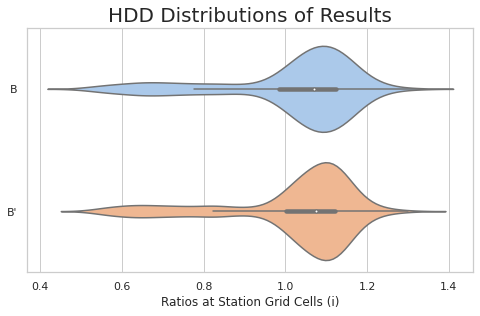

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 11895.527268168034 
UAA_station_mean 12882.913546666668 
Combined 12389.220407417351


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: deg C days


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 0.9991882246161599


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)